<a href="https://colab.research.google.com/github/Trid-Ilias/qpadm/blob/main/Experimental_ColabADMIXTOOLS_V5_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ColabADMIXTOOLS Version 5.0**
This notebook is designed to make it easier for people to model themselves (or just the AADR) using ADMIXTOOLS/ADMIXTOOLS2 (which includes qpAdm) with curated datasets. This notebook uses the AADR dataset from [here](https://reich.hms.harvard.edu/allen-ancient-dna-resource-aadr-downloadable-genotypes-present-day-and-ancient-dna-data).

You will need a Google account to be able to use Google Colaboratory. If you recieved this as a link, please make a copy for yourself using the **'File'** tab. If you received this a .ipynb, upload this notebook using the **'File'** tab.

Once the notebook is loaded, click **Connect** (top-right) to connect to a hosted runtime. CPU option should work fine with merging to the HO or just running AADR. To merge with 1240K, try v2-8 TPU runtime. We will be borrowing storage and a CPU from Google. As a result, nothing will be saved once you disconnect from the session. However, you may use the Colab File Explorer (left sidebar under security key) to view, open, and download intermediate or final results. See Step 7 to save any datasets to your Google Drive.

**Please visit Florio's GitHub Repo [Here](https://github.com/agonist11/colabadmixtools/) for a QuickStart Guide.**

# **[1] Install Software**

## **Setup Script for ADMIXTOOLS & ADMIXTOOLS2**
This guide explains the parameters and installation process for **ADMIXTOOLS**, **ADMIXTOOLS2**, **PLINK**, and other dependencies.

---

### **📌 Installation Preferences**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `install_admixtools` | `True` | If `True`, installs **ADMIXTOOLS** (DReichLab version) for f-statistics analysis. |
| `install_admixtools2` | `True` | If `True`, installs **ADMIXTOOLS 2**, an R-based implementation of f-statistics tools. |

---

### **📂 Dataset & SNP List Management**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `repo_url` | `"https://github.com/agonist11/colabadmixtools/raw/main/"` | GitHub repository where **SNP list files** are stored. |
| `snplist_files` | `["1240Ksnplistv62.snplist", "HOsnplistv62.snplist"]` | List of **SNP files** to be downloaded. |
| `snplist_dir` | `"/content"` | Directory where **SNP lists** are saved. |

---

### **📥 SNP List Download**
- If the required **SNP lists** (`1240Ksnplistv62.snplist`, `HOsnplistv62.snplist`) **do not exist**, they are **downloaded** from the GitHub repository.
---

### **🖥️ Installing Dependencies**
| **Dependency** | **Installation Command** | **Description** |
|--------------|------------------------|----------------|
| **R** | `sudo apt-get install -y r-base` | Installs R if not already available. |
| **rpy2** | `pip install rpy2` | Installs `rpy2` for running R inside Python (if not installed). |
| **PLINK** | `wget ... plink.zip && unzip` | Downloads and installs **PLINK** for genetic analysis. |

---

### **📌 Notes**
- **SNP lists** are downloaded **once** and are skipped if already present.
- If `install_admixtools = False`, **ADMIXTOOLS 1 will not be installed**.
- If `install_admixtools2 = False`, **ADMIXTOOLS2 (R) will not be installed**.


In [1]:
import os
from subprocess import run, PIPE

# @markdown **Select your preferences for the setup process. If asked to update dependencies, skip them by pressing Enter button**
install_admixtools = True  # @param {type:"boolean"}
install_admixtools2 = True  # @param {type:"boolean"}

# GitHub repository location
repo_url = "https://github.com/agonist11/colabadmixtools/raw/main/"
snplist_files = ["1240Ksnplistv62.snplist", "HOsnplistv62.snplist"]

# Function to check if a command exists
def command_exists(command):
    return run(['which', command], stdout=PIPE, stderr=PIPE).returncode == 0

# Create a folder for SNP lists
snplist_dir = "/content"
os.makedirs(snplist_dir, exist_ok=True)

# Download SNP lists from GitHub
for snplist in snplist_files:
    snplist_url = repo_url + snplist
    snplist_path = os.path.join(snplist_dir, snplist)

    if not os.path.exists(snplist_path):
        print(f"Downloading {snplist} from GitHub...")
        !wget -q -O {snplist_path} {snplist_url}
    else:
        print(f"{snplist} already exists.")

print("SNP lists downloaded and saved in /content")

# Install R if not installed
if not command_exists('R'):
    print("Installing R...")
    !sudo apt-get update -y
    !sudo apt-get install -y r-base
else:
    print("R is already installed.")

# Install rpy2 if not already installed
try:
    import rpy2
    print("rpy2 is already installed.")
except ImportError:
    print("Installing rpy2...")
    !pip install rpy2

# Load rpy2 extension
%load_ext rpy2.ipython

# Check for PLINK
if not os.path.exists('/content/plink'):
    print("Installing PLINK...")
    !wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20241022.zip -O plink.zip
    !unzip -o plink.zip -d /content/
    os.remove("plink.zip")
    print("PLINK installation complete!")
else:
    print("PLINK is already installed.")

# Check and install ADMIXTOOLS
if install_admixtools:
    if not os.path.exists('/content/AdmixTools'):
        print("Installing ADMIXTOOLS...")
        !apt-get update
        !apt-get install -y build-essential libgsl-dev libopenblas-dev gfortran liblapacke-dev \
                           libssl-dev libffi-dev libncurses5-dev zlib1g zlib1g-dev \
                           libreadline-dev libbz2-dev libsqlite3-dev
        !rm -rf AdmixTools
        !git clone https://github.com/DReichLab/AdmixTools.git
        %cd AdmixTools/src
        !sed -i "s/-Wimplicit/-Wimplicit -fcommon/" Makefile
        !make clobber
        !make all LDLIBS="-llapacke -llapack -lgsl -lopenblas -lm -lnick"
        !make install
        %cd /content/
        print("ADMIXTOOLS installation complete!")
    else:
        print("ADMIXTOOLS is already installed.")

# Check and install ADMIXTOOLS2
if install_admixtools2:
    try:
        import rpy2.robjects as ro
        print("Checking for ADMIXTOOLS2 installation...")
        ro.r('''
        if (!requireNamespace("admixtools", quietly = TRUE)) {
            stop("ADMIXTOOLS2 is not installed.")
        }
        ''')
        print("ADMIXTOOLS2 is already installed.")
    except Exception as e:
        print("Installing ADMIXTOOLS2...")
        ro.r('''
        lib_path <- "/usr/local/lib/R/site-library"
        install.packages("remotes", lib = lib_path)
        remotes::install_github("uqrmaie1/admixtools", dependencies = TRUE, lib = lib_path)
        ''')
        print("ADMIXTOOLS2 installation complete!")

print("Setup complete! SNP lists are available in /content")


SNP lists downloaded and saved in /content
R is already installed.
rpy2 is already installed.
Installing PLINK...
--2025-04-04 19:28:38--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20241022.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.43.136, 52.217.202.72, 54.231.141.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.43.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8954192 (8.5M) [application/zip]
Saving to: ‘plink.zip’

plink.zip           100%[===================>]   8.54M  45.7MB/s    in 0.2s    

2025-04-04 19:28:38 (45.7 MB/s) - ‘plink.zip’ saved [8954192/8954192]

Archive:  plink.zip
  inflating: /content/plink          
  inflating: /content/LICENSE        
  inflating: /content/toy.ped        
  inflating: /content/toy.map        
  inflating: /content/prettify       
PLINK installation complete!
Installing ADMIXTOOLS...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 

  ADMIXTOOLS2 is not installed.



/content
ADMIXTOOLS installation complete!
Checking for ADMIXTOOLS2 installation...
Installing ADMIXTOOLS2...








	‘/tmp/RtmpP0umEo/downloaded_packages’




These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                                
2: CRAN packages only                 
3: None                               
4: systemfonts (1.2.1 -> 1.2.2) [CRAN]

Enter one or more numbers, or an empty line to skip updates: 1
systemfonts  (1.2.1 -> 1.2.2   ) [CRAN]
lazyeval     (NA    -> 0.2.2   ) [CRAN]
parallelly   (NA    -> 1.43.0  ) [CRAN]
listenv      (NA    -> 0.9.1   ) [CRAN]
globals      (NA    -> 0.16.3  ) [CRAN]
iterators    (NA    -> 1.0.14  ) [CRAN]
crosstalk    (NA    -> 1.2.1   ) [CRAN]
future       (NA    -> 1.34.0  ) [CRAN]
foreach      (NA    -> 1.5.2   ) [CRAN]
shinydash... (NA    -> 0.7.2   ) [CRAN]
shinyWidgets (NA    -> 0.9.0   ) [CRAN]
shinythemes  (NA    -> 1.2.0   ) [CRAN]
shinyalert   (NA    -> 3.1.0   ) [CRAN]
shinyFiles   (NA    -> 0.9.3   ) [CRAN]
shinyBS      (NA    -> 0.61.1  ) [CRAN]
shinyjs      (NA    -> 2.1.0   ) [CRAN]
plotly       (




















































































































































	‘/tmp/RtmpP0umEo/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpP0umEo/remotes130261250b/uqrmaie1-admixtools-51b8517/DESCRIPTION’ ... OK
* preparing ‘admixtools’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘admixtools_2.0.8.tar.gz’

ADMIXTOOLS2 installation complete!
Setup complete! SNP lists are available in /content


**Both PLINK and rpy2 will be installed in any scenario. ADMIXTOOLS (AT1) installation is faster but model computation is slower. ADMIXTOOLS2 (AT2) installation is slower but model computation is faster. We recommend exploration and rotation strategy with AT2 and cross-referencing with AT1 afterwards (see Step 5 and Utility 6).**

# **[2] Your DNA File Upload**

**If you only want to model samples within the AADR you may skip this section and move to [3] Dataset Selection.**

## **DNA File Processing & Google Drive Management**
This script allows users to **upload, extract, copy, and convert** genomic files for use with **qpAdm** and other ADMIXTOOLS analyses.

---

### **📂 File Handling & Operations**
| **Operation** | **Description** |
|--------------|----------------|
| `1. Upload 23andMe File` | Uploads a **23andMe DNA file** to Colab. |
| `2. Upload & Convert AncestryDNA File` | Uploads and **converts AncestryDNA** format to **23andMe format**. |
| `3. Mount & Extract ZIP File` | Mounts **Google Drive** and extracts **a ZIP archive**. |
| `4. Mount & Copy SNP Lists` | Mounts Google Drive and **copies SNP list files** for analysis. |
| `5. Convert DNA File to 23andMe Format` | Converts **MyHeritage, FTDNA, or AncestryDNA files** to **23andMe format**. |

---

### **🔄 File Conversion Parameters**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `input_file` | `"/content/MyHeritage_Example_dna_data.csv"` | Path to the **DNA file** to be converted. |
| `input_format` | `"myheritage"` | Input format: **23andme, ancestry, myheritage, ftdnav1, ftdnav2**. |
| `output_file` | `"MHconverted_23andme.txt"` | Name of the converted output file. |

---

### **📌 Google Drive & File Management**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `zip_folder_path` | `"/content/drive/MyDrive/colabadmixtools/Example_mergedHO.zip"` | Path to a ZIP file for extraction. For those returning and already performed Step 7 below. |
| `snp_list_folder_path` | `"/content/drive/MyDrive/colabadmixtools/snplists"` | Path to a folder containing **SNP lists**. |

---

### **✅ Notes**
- **Google Drive must be mounted** for ZIP extraction and SNP file copying.
- The script **automatically detects the user-selected operation** and runs the appropriate function.
- **File format conversion** ensures compatibility with ADMIXTOOLS.

---


**23andMe formatted data works best for conversion. Please explore [DNA Kit Studio](https://www.dnagenics.com/dna-kit-studio/) on how to make this conversion possible. Some users have also found success with [this](https://tendna.com/en/dna-converter) converter as well.**

**Select Operation 1 from the dropdown and run the code cell to upload your 23andMe file. Select Operation 2 to upload AncestryDNA and convert it. Select Operation 3 if you are returning and you did Step 7 previously. Select Operation 4 if you have different snplists to upload from your Drive. Select Operation 5 if you have MyHeritage or FTDNA and fill in the rest before running the code cell.**

In [ ]:
# Import necessary libraries
from google.colab import files, drive
import os
import zipfile
import shutil

#@markdown ## **Choose an Operation**
operation = "3. Mount & Extract ZIP File"  #@param ["1. Upload 23andMe File", "2. Upload & Convert AncestryDNA File", "3. Mount & Extract ZIP File", "4. Mount & Copy SNP Lists", "5. Convert DNA File to 23andMe Format"]

# Upload and process genome files
def upload_genome(file_type="23andMe"):
    uploaded = files.upload()
    if uploaded:
        filename = next(iter(uploaded))
        print(f"File '{filename}' uploaded successfully.")
        if file_type == "AncestryDNA":
            process_ancestry_file(filename)
    else:
        print("No file uploaded.")

# Convert AncestryDNA to 23andMe format
def convert_ancestry_to_23andme(content):
    lines = content.strip().split("\n")
    header_end_idx = next(i for i, line in enumerate(lines) if line.startswith("rsid"))
    data_lines = lines[header_end_idx+1:]

    converted_lines = ["# rsid\tchromosome\tposition\tgenotype"]
    for line in data_lines:
        parts = line.split("\t")
        if len(parts) == 5:
            rsid, chromosome, position, allele1, allele2 = parts
            genotype = allele1 + allele2
            converted_lines.append(f"{rsid}\t{chromosome}\t{position}\t{genotype}")

    return "\n".join(converted_lines)

# Process AncestryDNA file
def process_ancestry_file(filename):
    with open(filename, "r") as f:
        content = f.read()

    if "AncestryDNA raw data download" in content:
        print(f"Converting '{filename}' to 23andMe format...")
        converted_content = convert_ancestry_to_23andme(content)
        converted_filename = filename.replace(".txt", "_converted.txt")

        with open(converted_filename, "w") as f:
            f.write(converted_content)

        print(f"File converted and saved as '{converted_filename}'.")
    else:
        print(f"File '{filename}' does not appear to be in AncestryDNA format.")

#@markdown **Operation 3. Path to ZIP file (if extracting, otherwise leave blank):**
zip_folder_path = "/content/drive/MyDrive/colabadmixtools/Example_mergedHO.zip"  #@param {type:"string"}

# Mount Google Drive and extract ZIP files
def mount_and_extract(zip_folder_path):
    drive.mount('/content/drive')
    zip_file_path = os.path.join('/content/drive/MyDrive/', zip_folder_path)

    if os.path.exists(zip_file_path) and zip_file_path.endswith('.zip'):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall('/content/')
            print(f"Contents of '{zip_folder_path}' extracted to '/content/'")
    else:
        print(f"Zip file not found at '{zip_folder_path}'.")

#@markdown **Operation 4. Path to SNP list folder (if copying SNPs, otherwise leave blank):**
snp_list_folder_path = "/content/drive/MyDrive/colabadmixtools/snplists"  #@param {type:"string"}

# Mount Google Drive and copy SNP lists
def mount_and_copy_snp_lists(snp_list_folder_path):
    drive.mount('/content/drive')

    if os.path.exists(snp_list_folder_path) and os.path.isdir(snp_list_folder_path):
        destination_folder = '/content/'
        os.makedirs(destination_folder, exist_ok=True)

        for item in os.listdir(snp_list_folder_path):
            source = os.path.join(snp_list_folder_path, item)
            destination = os.path.join(destination_folder, item)
            if os.path.isfile(source):
                shutil.copy2(source, destination)
            elif os.path.isdir(source):
                shutil.copytree(source, destination, dirs_exist_ok=True)

        print(f"Contents of '{snp_list_folder_path}' copied to '{destination_folder}'")
    else:
        print(f"Folder not found at '{snp_list_folder_path}'.")

# Set up and run terraseq DNA file conversion
def setup_terraseq():
    terraseq_url = "https://github.com/enelsr/terraseq/releases/latest/download/terraseq"
    os.system(f"wget -O terraseq {terraseq_url}")
    os.system("chmod +x terraseq")
    print("terraseq setup completed successfully.")

#@markdown **Operation 5. Specify the file path of your DNA file (if converting from MyHeritage or FTDNA, otherwise leave blank):**
input_file = "/content/MyHeritage_Example_dna_data.csv"  #@param {type:"string"}

#@markdown **Select the input file format (for Operation 5: otherwise do not change):**
input_format = "myheritage"  #@param ["23andme", "ancestry", "myheritage", "ftdnav1", "ftdnav2"]

#@markdown **Specify the output file name (for Operation 5, otherwise leave blank):**
output_file = "MHconverted_23andme.txt"  #@param {type:"string"}

def convert_dna_file(input_file, input_format, output_file):
    if not os.path.exists(input_file):
        print(f"Error: The file path '{input_file}' does not exist.")
        return

    print(f"Converting {input_file} from {input_format} to 23andMe format...")
    command = f"./terraseq convert --inFile {input_file} --inFormat {input_format} --outFormat 23andme --outFile {output_file}"
    os.system(command)

    if os.path.exists(output_file):
        print(f"Conversion successful! Output file: {output_file}")
    else:
        print("Conversion failed. Please check your input file and format.")

# **Execution Logic Based on User Selection**
if operation == "1. Upload 23andMe File":
    upload_genome("23andMe")

elif operation == "2. Upload & Convert AncestryDNA File":
    upload_genome("AncestryDNA")

elif operation == "3. Mount & Extract ZIP File":
    mount_and_extract(zip_folder_path)

elif operation == "4. Mount & Copy SNP Lists":
    mount_and_copy_snp_lists(snp_list_folder_path)

elif operation == "5. Convert DNA File to 23andMe Format":
    setup_terraseq()
    convert_dna_file(input_file, input_format, output_file)


**If you do not have the snplists, modeling your sample can lead to high Standard Errors. Please ask whoever sent you this notebook to provide you the snplists. Then use the Optional Step above if it is in your Google Drive or manually upload them to this session using the Upload function on the left.**

**Update: By running Step 1, you should already have the snplists downloaded already now and visible in the colab File Explorer.**

# **[3] Dataset Selection**

**The 1240K has more coverage than the 1240K+HO. However, the 1240K+HO has more modern samples. You can download one after the other if you would like to explore both datasets.**

## **Download 1240K or HO Datasets (AADR v62)**
This script downloads **ancient DNA reference datasets** from the **Allen Ancient DNA Resource (AADR v62)**.

### **📌 Dataset Options**
| **Option** | **Files Downloaded** |
|-----------|----------------------|
| `1240K` | 1240K dataset (geno, ind, snp, anno, Excel) |
| `1240K+HO` | 1240K + Human Origins dataset (geno, ind, snp, anno, Excel) |

### **🔽 How It Works**
- **Select a dataset** (`1240K` or `1240K+HO`).
- Downloads the corresponding files from **Harvard Dataverse**.
- Saves them in `/content/`.

### **✅ Notes**
- Ensure enough storage space before downloading.
- Files will be stored in **Colab’s workspace**.


In [ ]:
# @title **Download 1240K or HO Datasets (AADR v62)**
# @markdown Select the dataset you want to download:

dataset_choice = "1240K+HO" #@param ["1240K", "1240K+HO"]

# Define the URLs and corresponding filenames for each dataset
dataset_files = {
    "1240K": [
        ("https://dataverse.harvard.edu/api/access/datafile/10537413", "aadr_v62.0_1240K_public.anno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537126", "aadr_v62.0_1240K_public.geno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537414", "aadr_v62.0_1240K_public.ind"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537415", "aadr_v62.0_1240K_public.snp"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537416", "v62.0_1240K_public.xlsx")
    ],
    "1240K+HO": [
        ("https://dataverse.harvard.edu/api/access/datafile/10537417", "aadr_v62.0_HO_public.anno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537419", "aadr_v62.0_HO_public.geno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537420", "aadr_v62.0_HO_public.ind"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537421", "aadr_v62.0_HO_public.snp"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537422", "v62.0_HO_public.xlsx")
    ]
}

selected_files = dataset_files[dataset_choice]

print(f"Downloading {dataset_choice} dataset files...")
for url, filename in selected_files:
    !wget --no-check-certificate {url} -O /content/{filename}

print("Download complete!")

**Look for the associated .xlsx spreadsheet on the left File Explorer to look at all the samples in the dataset. When modeling, we refer to the Group ID, which may contain one or more samples.**

# **[4] Merging Yourself with the AADR**

#### **You can skip to Step 5 if you just want to model within the AADR. For now, only merging with the +HO dataset is possible on a regular CPU Python 3 runtime. Change runtime to TPU v2-8 to merge with the 1240K.**

## **Data Processing & Merging**
This script **converts, trims, and merges** a **23andMe** genetic file with reference datasets for use in **ADMIXTOOLS**.

---

### **📂 Input Parameters**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `genome_filepath` | `"/content/merged_Example_genome.txt"` | Path to the **23andMe TXT file**. |
| `output_base` | `"Example"` | Prefix for output files. |
| `sex_code` | `"1"` | Defines the **sex in .fam file** (1 = male, 2 = female, 0 = unknown). |

---

### **🔍 Optional Settings**
| **Option** | **Default** | **Description** |
|--------------|------------|----------------|
| `trim_with_snplist` | `True` | If `True`, trims the dataset using a **SNP list**. |
| `snplist_path` | `"/content/HOsnplistv62.snplist"` | Path to the **SNP list** (if trimming is enabled). |

---

### **🔗 Dataset Merging Parameters**
| **Parameter** | **Example** | **Description** |
|--------------|------------|----------------|
| `geno1_path` | `"/content/aadr_v62.0_HO_public.geno"` | First dataset **geno file**. |
| `snp1_path` | `"/content/aadr_v62.0_HO_public.snp"` | First dataset **snp file**. |
| `ind1_path` | `"/content/aadr_v62.0_HO_public.ind"` | First dataset **ind file**. |
| `num_threads` | `2` | Number of threads for **mergeit**. |

---

### **🛠️ Process Overview**
1. **Creates Swap Memory** to prevent out-of-memory errors.
2. **Converts 23andMe file** to **PLINK format**.
3. **Updates the .fam file** with correct metadata.
4. **Trims dataset** using a SNP list (if enabled).
5. **Converts PLINK data** to **PACKEDANCESTRYMAP format**.
6. **Merges dataset** with AADR Dataset files.
7. **Verifies merged dataset**.

---

### **✅ Notes**
- If `trim_with_snplist = True`, the **SNP list must be provided**.

---


In [ ]:
import os
import subprocess

# @markdown ### Step 1: Specify Inputs

# @markdown **Filepath to your 23andMe TXT File**:
genome_filepath = "/content/merged_Florio_genome.txt"  # @param {type:"string"}

# @markdown **Output Base Prefix**: Define a name for intermediate and final files.
output_base = "Florio"  # @param {type:"string"}

# @markdown **.fam File Parameters**:
# @markdown These fields will auto-fill based on `output_base`, but you can edit `sex_code` as needed.
family_id = output_base  # Automatically set to output_base
individual_id = output_base  # Automatically set to output_base
father_id = '0'  # Always 0
mother_id = '0'  # Always 0
sex_code = '1'  # @param ["1", "2", "0"]  # Default is 1 (male)
phenotype_value = '0'  # Always 0

# @markdown ---
# @markdown **Trim Using SNP List?**
trim_with_snplist = True  # @param {type:"boolean"}

# @markdown **If Trimming**, specify:
snplist_path = "/content/HOsnplistv62.snplist"  # @param {type:"string"}

# @markdown ---
# @markdown ### Merge Dataset Parameters
# @markdown Specify the file paths for the dataset you want to merge with:
geno1_path = "/content/aadr_v62.0_HO_public.geno"  # @param {type:"string"}
snp1_path = "/content/aadr_v62.0_HO_public.snp"  # @param {type:"string"}
ind1_path = "/content/aadr_v62.0_HO_public.ind"  # @param {type:"string"}

# @markdown **Number of Threads for Mergeit**:
num_threads = 2  # @param {type:"integer"}

# Ensure required inputs are valid
if not genome_filepath:
    raise ValueError("Please specify the filepath to your 23andMe TXT file.")
if not output_base:
    raise ValueError("Please specify an output base name.")
if not geno1_path or not snp1_path or not ind1_path:
    raise ValueError("Please specify the file paths for the dataset to merge with.")

# Define paths dynamically based on user inputs
fam_file_path = f"/content/{output_base}.fam"
plink_file_prefix = f"/content/{output_base}"
if trim_with_snplist:
    output_base_trimmed = f"{output_base}trimmed"
    plink_file_prefix = f"/content/{output_base_trimmed}"

# Paths for EIGENSTRAT conversion
bedfilepath = f"/content/{output_base_trimmed}.bed" if trim_with_snplist else f"/content/{output_base}.bed"
bimfilepath = f"/content/{output_base_trimmed}.bim" if trim_with_snplist else f"/content/{output_base}.bim"
famfilepath = f"/content/{output_base_trimmed}.fam" if trim_with_snplist else f"/content/{output_base}.fam"
genotypeoutname = f"{output_base}_converted.geno"
snpoutname = f"{output_base}_converted.snp"
indivoutname = f"{output_base}_converted.ind"

# Paths for merging datasets
geno2_path = genotypeoutname
snp2_path = snpoutname
ind2_path = indivoutname
output_geno_path = f"{output_base}_merged.geno"
output_snp_path = f"{output_base}_merged.snp"
output_ind_path = f"{output_base}_merged.ind"

# Step 2: Add Swap Memory to Prevent Out-of-Memory Issues
print("Creating swap memory...")
swap_file_path = "/swapfile"
os.system(f"fallocate -l 8G {swap_file_path}")
os.system(f"chmod 600 {swap_file_path}")
os.system(f"mkswap {swap_file_path}")
os.system(f"swapon {swap_file_path}")
print("Swap memory created successfully.")

# Step 3: Add AdmixTools to PATH
print("Adding AdmixTools to PATH...")
os.environ['PATH'] += os.pathsep + "/content/AdmixTools/bin"
!which qpfstats

# Step 4: Convert Genome File with PLINK
print("Running PLINK conversion...")
!{os.path.join('/content', 'plink')} --23file {genome_filepath} --list-23-indels --allow-no-sex --make-bed --out {output_base}

# Step 5: Update the .fam File
print("Updating .fam file...")
new_fam_line = f"{family_id} {individual_id} {father_id} {mother_id} {sex_code} {phenotype_value}\n"
with open(fam_file_path, 'w') as fam_file:
    fam_file.write(new_fam_line)
print(f".fam file updated successfully: {fam_file_path}")

# Step 6: Trim PLINK File Using SNP List (if selected)
if trim_with_snplist:
    if not os.path.isfile(snplist_path):
        raise ValueError(f"Selected SNP list file '{snplist_path}' does not exist.")
    print("Trimming PLINK file...")
    trim_command = f"/content/plink --bfile {output_base} --extract {snplist_path} --make-bed --allow-no-sex --out {output_base_trimmed}"
    subprocess.run(trim_command, shell=True, check=True)
    print(f"Trimmed PLINK file created: {output_base_trimmed}")

# Step 7: Create Parameter File for EIGENSTRAT Conversion
print("Creating convertf parameter file...")
convertf_param_content = f"""
genotypename: {bedfilepath}
snpname: {bimfilepath}
indivname: {famfilepath}
genotypeoutname: {genotypeoutname}
snpoutname: {snpoutname}
indivoutname: {indivoutname}
prodercheck: YES
"""
with open("/content/convertf_param.par", "w") as param_file:
    param_file.write(convertf_param_content)
print("convertf parameter file created successfully.")

# Step 8: Convert PLINK to PACKEDANCESTRYMAP
print("Running convertf...")
!convertf -p /content/convertf_param.par

# Step 9: Create Parameter File for Dataset Merging
print("Creating mergeit parameter file...")
mergeit_param_content = f"""
geno1: {geno1_path}
snp1: {snp1_path}
ind1: {ind1_path}
geno2: {geno2_path}
snp2: {snp2_path}
ind2: {ind2_path}
genooutfilename: {output_geno_path}
snpoutfilename: {output_snp_path}
indoutfilename: {output_ind_path}
testmismatch: NO
numthreads: {num_threads}
"""
with open("/content/mergeit_param.par", "w") as merge_param_file:
    merge_param_file.write(mergeit_param_content)
print("mergeit parameter file created successfully.")

# Step 10: Run mergeit
print("Merging datasets...")
!mergeit -p /content/mergeit_param.par

# Step 11: Verify Merging Results
print("Verifying merged files...")
merged_files_exist = all(os.path.exists(file) for file in [output_geno_path, output_snp_path, output_ind_path])
if merged_files_exist:
    print("Merging completed successfully.")
else:
    print("An error occurred during merging.")


**While the previous step is running, I urge you to use the File Explorer and double-click on the AADR .xlsx file. The 1st column is the family+individual ID. The 2nd column is the sex (M, F, unspecified). The 3rd column is the sample label: Scroll through the labels and start to form a list of right populations and left populations (samples you think you are admixed with). The number of left/source populations must be less than or equal to the number of right/reference. Read through [this](https://pmc.ncbi.nlm.nih.gov/articles/PMC8049561/) paper to obtain insight into the theory.**

# **[5] AT2 qpAdm Prep and Running**

**You should now have a dataset with your data merged in. Use the File Explorer and double-click the .ind file. It should open on the right and your sample will be ALL the way at the bottom with ??? in the 3rd label. Manually rename yourself with your desired label and remove spaces such that there is only one space between your sex and label.**
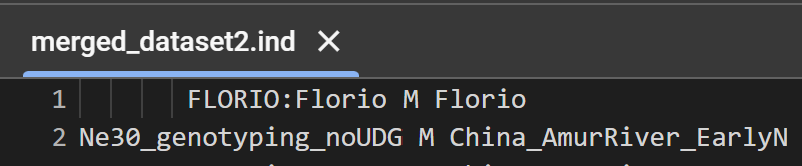

## **qpAdm Parameters (ADMIXTOOLS2)**
This guide explains the parameters used in `qpAdm`, along with their **default values** and **descriptions**.

---

### **📂 Dataset & Populations**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `prefix` | `/content/dataset` | Prefix for genotype files (`.ind`, `.snp`, `.geno`). |
| `left_poplist` | `"Example.AG,..."` | Comma-separated list of **source (left) populations**. |
| `right_poplist` | `"Mbuti.DG,..."` | Comma-separated list of **outgroup (right) populations**. |
| `target` | `"Target.DG"` | The **target population** being modeled. |

---

### **📄 Output Files**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `weights_file` | `"weights1.csv"` | File to store **admixture weight results**. |
| `popdrop_file` | `"popdrop1.csv"` | File to store **population drop results**. |

---

### **⚙️ qpAdm Model Parameters**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `allsnps` | `True` | If `True`, each f4-statistic uses **all available SNPs** instead of the full intersection across populations. |
| `fudge` | `1e-04` | A **small constant** added to the covariance matrix diagonal before inversion to stabilize calculations. |
| `fudge_twice` | `False` | If `True`, applies `fudge` a second time to **match qpAdm’s original implementation**. |
| `boot` | `False` | If `True`, enables **bootstrap resampling** for standard errors. Default is **jackknife resampling**. |
| `getcov` | `True` | If `False`, skips covariance matrix calculation (for faster runs). |
| `constrained` | `False` | If `True`, constrains admixture proportions to be **non-negative** (0 to 1). |
| `return_f4` | `False` | If `True`, returns **f4-statistics** in addition to admixture weights. |

---

### **🔧 Computational Options**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `cpp` | `True` | If `True`, uses **C++ optimizations** for faster execution. If `False`, runs in **pure R** (useful for debugging). |
| `verbose` | `True` | If `True`, prints **detailed status updates** during execution. |

---

### **🔌 UI & Debugging**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `detach_shinyjs` | `True` | Ensures `shinyjs` is detached to **prevent UI conflicts in R-based interfaces**. |

---

### **📌 Notes**
- **Required Parameters**: `prefix`, `left_poplist`, `right_poplist`, `target`
- **Performance Tweaks**:
  - Use `allsnps = True` if working with **sparse datasets**.
  - Set `cpp = False` if debugging **computation errors**.
  - Use `getcov = False` for **faster runs** with large datasets.

---

In [111]:
# Dataset prefix
prefix = "/content/Saif1240Kmerged_merged"  # @param {type:"string"}

# Populations (can be comma-separated string or quoted list)
left_poplist = "Tunisia_Kerkouane_Punic_oAfrica1.SG1, Spain_LIA.AG"  # @param {type:"string"}
right_poplist = " Turkey_Marmara_Barcin_N.AG,ZNF,CHG,EHG1,Russia_Tyumen_HG.DG,Morocco_Iberomaurusian.AG,Israel_Natufian1.AG,Cameroon_ShumLaka_SMA.AG, Luxembourg_Mesolithic.DG,Russia_Tyumen_N.AG"  # @param {type:"string"}
target = 'Papa'  # @param {type:"string"}

# File names for outputs
weights_file = "weights1.csv"  # @param {type:"string"}
popdrop_file = "popdrop1.csv"  # @param {type:"string"}

# Additional qpAdm options
detach_shinyjs = True  # @param {type:"boolean"}
allsnps = True  # @param {type:"boolean"}
fudge = 1e-04  # @param {type:"number"}
fudge_twice = False  # @param {type:"boolean"}
boot = False  # @param {type:"boolean"}
getcov = True  # @param {type:"boolean"}
constrained = False  # @param {type:"boolean"}
return_f4 = False  # @param {type:"boolean"}
cpp = True  # @param {type:"boolean"}
verbose = True  # @param {type:"boolean"}

# Function to parse population lists
def parse_poplist(poplist):
    if isinstance(poplist, str):
        return [pop.strip().strip("'") for pop in poplist.split(',')]
    return poplist

# Parse the population lists
left = parse_poplist(left_poplist)
right = parse_poplist(right_poplist)

import rpy2.robjects as robjects

# Pass the parameters to the R environment
robjects.globalenv['prefix'] = prefix
robjects.globalenv['left'] = robjects.StrVector(left)
robjects.globalenv['right'] = robjects.StrVector(right)
robjects.globalenv['target'] = target
robjects.globalenv['weights_file'] = weights_file
robjects.globalenv['popdrop_file'] = popdrop_file
robjects.globalenv['detach_shinyjs'] = detach_shinyjs
robjects.globalenv['allsnps'] = allsnps
robjects.globalenv['fudge'] = fudge
robjects.globalenv['fudge_twice'] = fudge_twice
robjects.globalenv['boot'] = boot
robjects.globalenv['getcov'] = getcov
robjects.globalenv['constrained'] = constrained
robjects.globalenv['return_f4'] = return_f4
robjects.globalenv['cpp'] = cpp
robjects.globalenv['verbose'] = verbose


In [112]:
#@markdown **Run qpAdm (AT2)**

%%R
# Load necessary libraries
library(admixtools)
library(tidyverse)

# Retrieve parameters from Python
prefix <- get("prefix", envir = .GlobalEnv)
left <- get("left", envir = .GlobalEnv)
right <- get("right", envir = .GlobalEnv)
target <- get("target", envir = .GlobalEnv)
weights_file <- get("weights_file", envir = .GlobalEnv)
popdrop_file <- get("popdrop_file", envir = .GlobalEnv)
detach_shinyjs <- get("detach_shinyjs", envir = .GlobalEnv)
allsnps <- get("allsnps", envir = .GlobalEnv)
fudge <- get("fudge", envir = .GlobalEnv)
fudge_twice <- get("fudge_twice", envir = .GlobalEnv)
boot <- get("boot", envir = .GlobalEnv)
getcov <- get("getcov", envir = .GlobalEnv)
constrained <- get("constrained", envir = .GlobalEnv)
return_f4 <- get("return_f4", envir = .GlobalEnv)
cpp <- get("cpp", envir = .GlobalEnv)
verbose <- get("verbose", envir = .GlobalEnv)

# Detach shinyjs if specified
if (detach_shinyjs) {
  try(detach("package:shinyjs", unload=TRUE), silent=TRUE)
}

# Print parameters for verification
print(paste("Prefix path: ", prefix))
print(paste("Left populations: ", toString(left)))
print(paste("Right populations: ", toString(right)))
print(paste("Target population: ", target))
print(paste("Weights file: ", weights_file))
print(paste("Popdrop file: ", popdrop_file))
print(paste("Detach shinyjs: ", detach_shinyjs))
print(paste("All SNPs: ", allsnps))
print(paste("Fudge factor: ", fudge))
print(paste("Fudge twice: ", fudge_twice))
print(paste("Bootstrap resampling: ", boot))
print(paste("Compute covariance: ", getcov))
print(paste("Constrain weights: ", constrained))
print(paste("Return f4 statistics: ", return_f4))
print(paste("Use C++ functions: ", cpp))
print(paste("Verbose mode: ", verbose))

# Execute qpAdm analysis
results <- qpadm(prefix,
                 left,
                 right,
                 target,
                 allsnps = allsnps,
                 fudge = fudge,
                 fudge_twice = fudge_twice,
                 boot = boot,
                 getcov = getcov,
                 constrained = constrained,
                 return_f4 = return_f4,
                 cpp = cpp,
                 verbose = verbose)

# Set output options
options(dplyr.width = Inf, max.print = 100000, digits = 10)

# Save results
write.csv(results$weights, weights_file, row.names = FALSE)
write.csv(results$popdrop, popdrop_file, row.names = FALSE)

# Print results
print(results$weights, n = Inf)
print(results$popdrop, n = Inf)

if ("f4" %in% names(results)) {
  print(results$f4, n = Inf)
}

print("qpAdm analysis complete. Results are also saved in CSV files.")


[1] "Prefix path:  /content/Saif1240Kmerged_merged"
[1] "Left populations:  Tunisia_Kerkouane_Punic_oAfrica1.SG1, Spain_LIA.AG, Italy_Imperial.SG"
[1] "Right populations:  Turkey_Marmara_Barcin_N.AG, ZNF, CHG, EHG1, Russia_Tyumen_HG.DG, Morocco_Iberomaurusian.AG, Israel_Natufian1.AG, Cameroon_ShumLaka_SMA.AG, Luxembourg_Mesolithic.DG, Russia_Tyumen_N.AG"
[1] "Target population:  Papa"
[1] "Weights file:  weights1.csv"
[1] "Popdrop file:  popdrop1.csv"
[1] "Detach shinyjs:  TRUE"
[1] "All SNPs:  TRUE"
[1] "Fudge factor:  1e-04"
[1] "Fudge twice:  FALSE"
[1] "Bootstrap resampling:  FALSE"
[1] "Compute covariance:  TRUE"
[1] "Constrain weights:  FALSE"
[1] "Return f4 statistics:  FALSE"
[1] "Use C++ functions:  TRUE"
[1] "Verbose mode:  TRUE"
ℹ Reading metadata...
ℹ Computing block lengths for 144078 SNPs...

ℹ "allsnps = TRUE" uses different SNPs for each f4-statistic
  Number of SNPs used for each f4-statistic:
   pop1                                 pop2                       pop3
1  P

  target                                  left    weight        se          z  \
0   Papa  Tunisia_Kerkouane_Punic_oAfrica1.SG1  0.798297  0.049989  15.969539   
1   Papa                          Spain_LIA.AG  0.064698  0.119103   0.543210   
2   Papa                     Italy_Imperial.SG  0.137005  0.140873   0.972540   

   Admixture Proportion  Standard Error  
0             79.829748        4.998876  
1              6.469768       11.910251  
2             13.700484       14.087322  


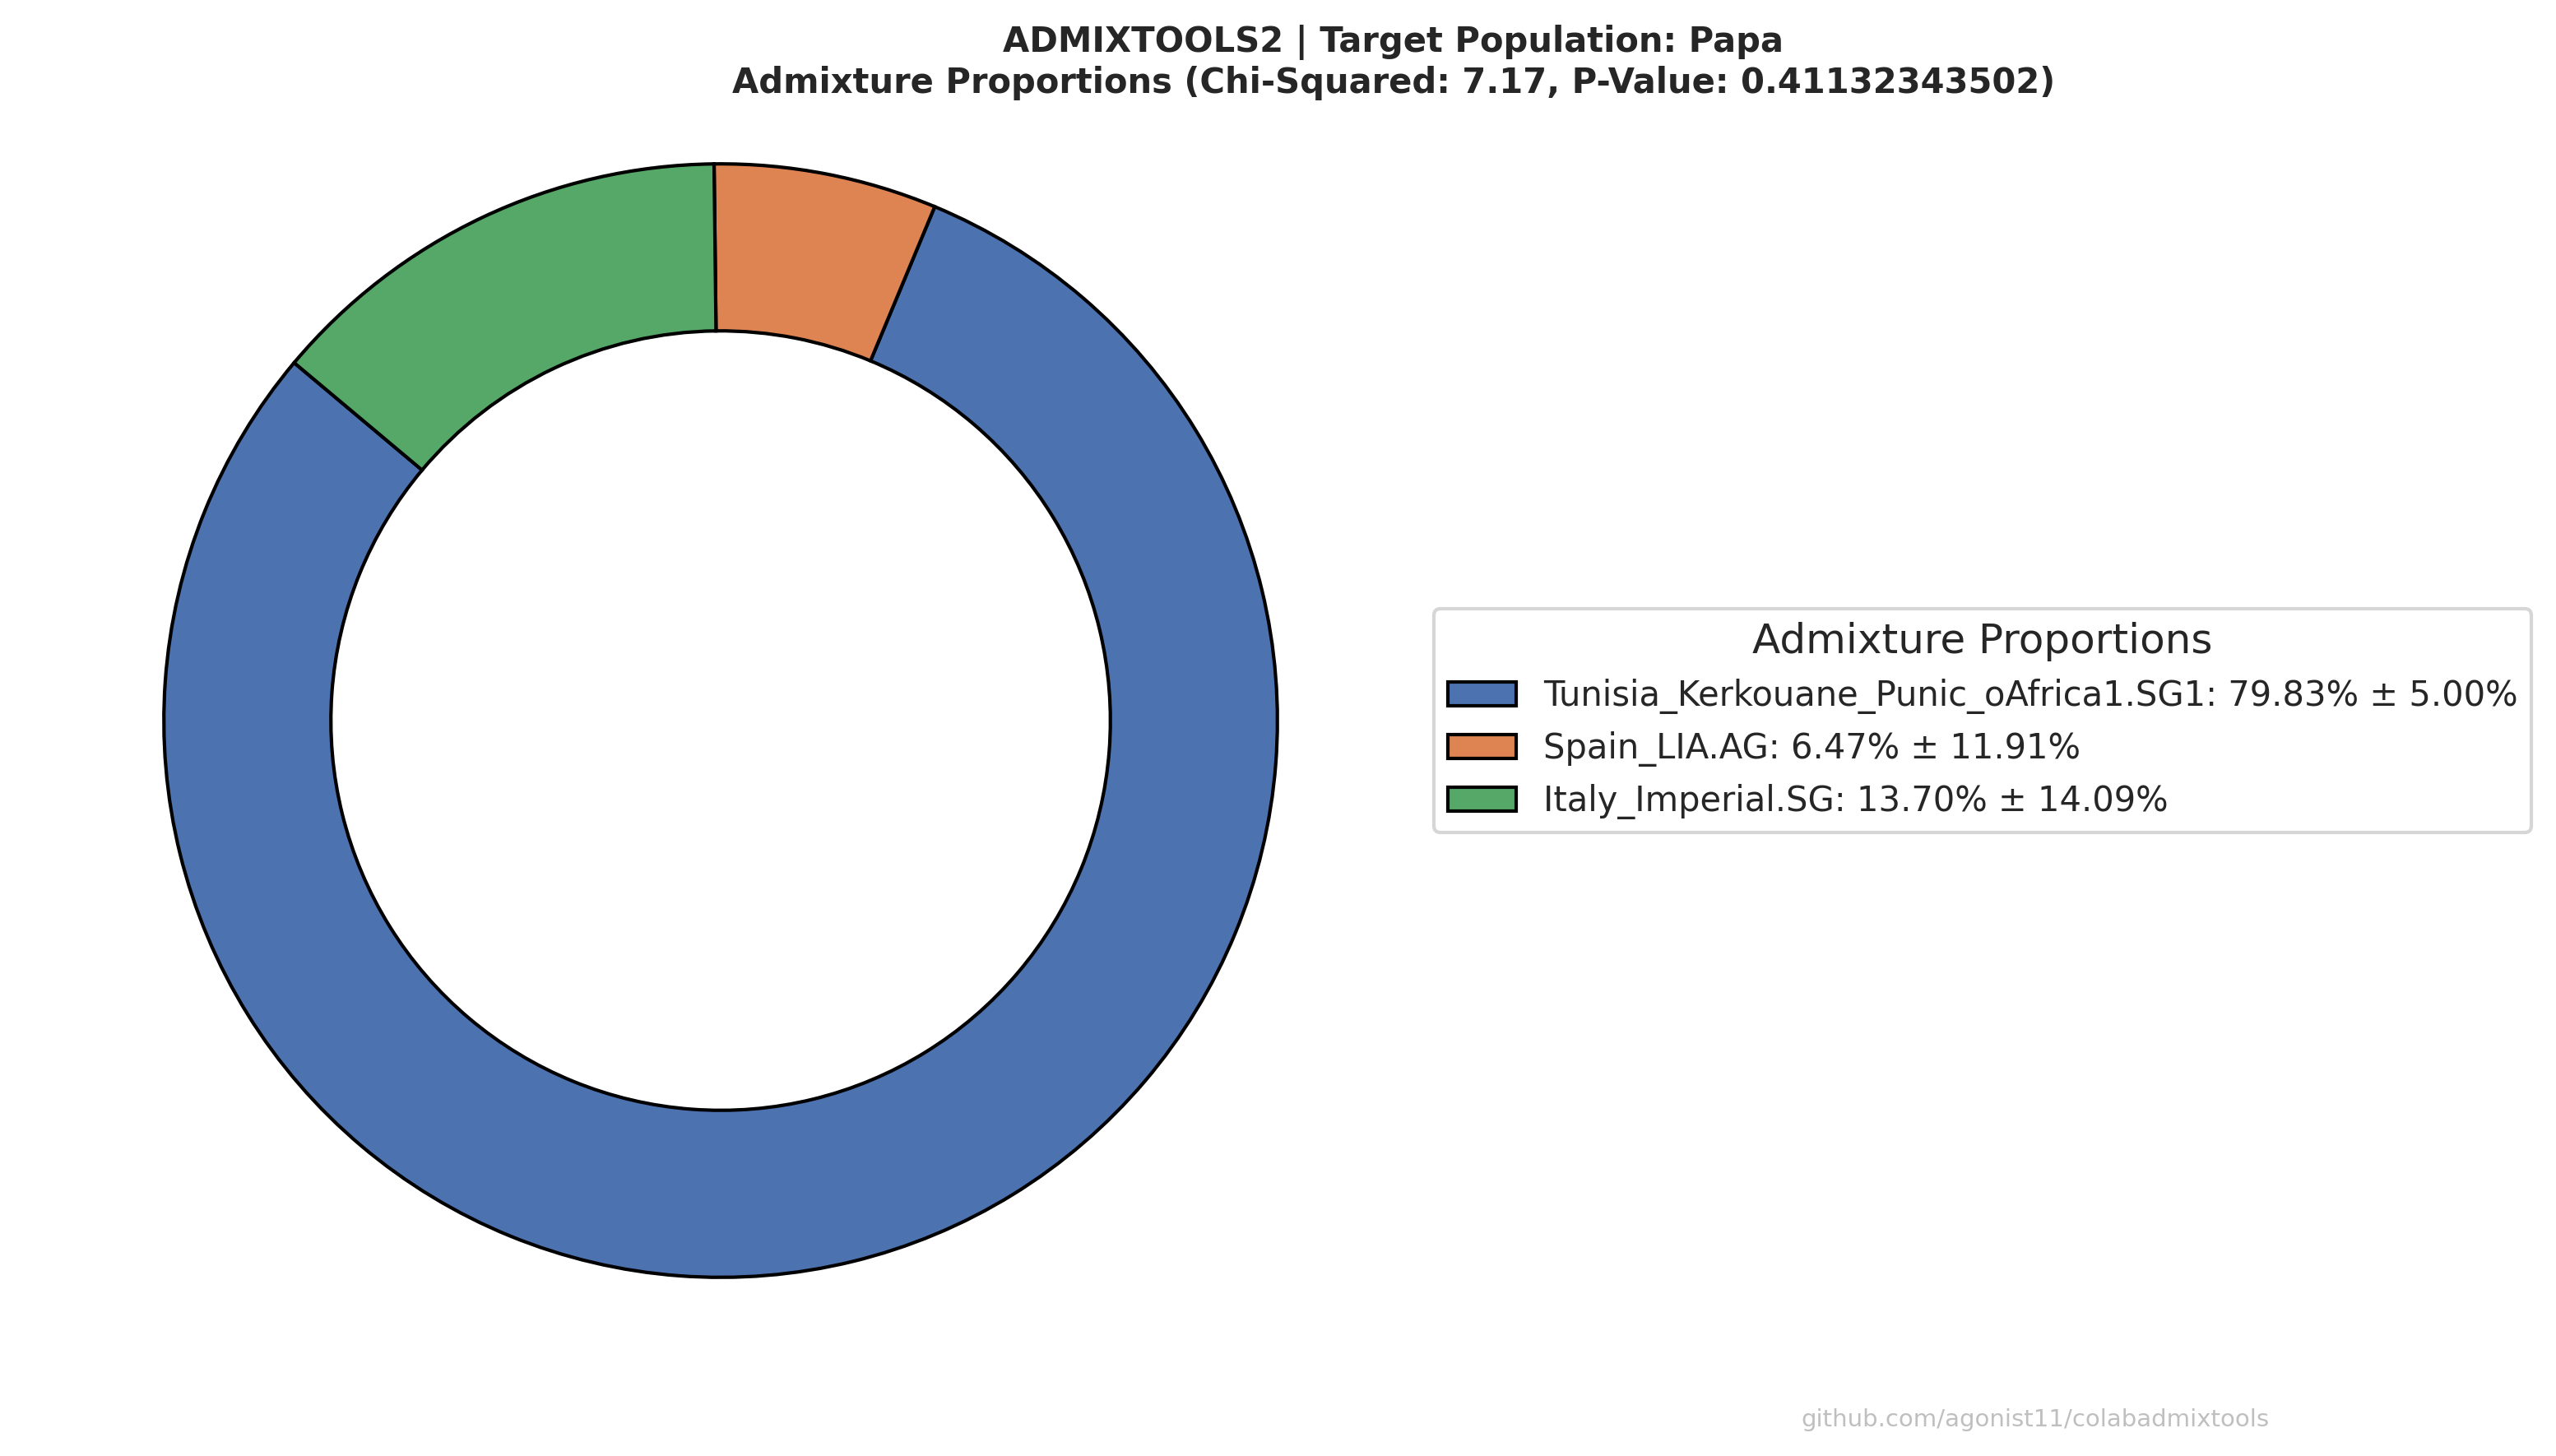

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import numpy as np

# @title **Parse and Visualize qpAdm (AT2) Output**
# @markdown Please paste the paths to your qpAdm weights and popdrop files:
weights_file = "/content/weights1.csv"  # @param {type:"string"}
popdrop_file = "/content/popdrop1.csv"  # @param {type:"string"}

def parse_qpadm_at2(weights_file, popdrop_file):
    try:
        # Load the weights file (admixture proportions)
        df_weights = pd.read_csv(weights_file)

        if not {'target', 'left', 'weight', 'se'}.issubset(df_weights.columns):
            raise ValueError("Missing required columns in the weights file.")

        target_population = df_weights["target"].iloc[0]

        # Convert proportions to percentages
        df_weights["Admixture Proportion"] = df_weights["weight"] * 100
        df_weights["Standard Error"] = df_weights["se"] * 100

        # Handle case where qpAdm reports 0.0 proportions
        if df_weights["Admixture Proportion"].sum() == 0 and len(df_weights) == 1:
            df_weights["Admixture Proportion"] = 100.0
            df_weights["Standard Error"] = 0.0

        # Load the popdrop file (chi-squared & p-value)
        df_popdrop = pd.read_csv(popdrop_file)

        if not {'chisq', 'p'}.issubset(df_popdrop.columns):
            raise ValueError("Missing required columns in the popdrop file.")

        chi_squared = df_popdrop["chisq"].iloc[0] if not df_popdrop.empty else 0.0
        p_value = df_popdrop["p"].iloc[0] if not df_popdrop.empty else 1.0

        return df_weights, target_population, chi_squared, p_value

    except Exception as e:
        print(f"Error parsing qpAdm (AT2) output: {e}")
        return pd.DataFrame(), '', 0.0, 1.0

# Parse the results
df_admixture, target_population, chi_squared, p_value = parse_qpadm_at2(weights_file, popdrop_file)

if not df_admixture.empty:
    print(df_admixture)
else:
    print("Parsed DataFrame is empty or an error was encountered.")

# @title Select Plot Type
# @markdown Choose the type of plot to display:
plot_type = "Pie Chart"  # @param ["Bar Graph", "Pie Chart"]

def wrap_text(text, width=50):
    wrapped_lines = textwrap.wrap(text, width)
    return "\n".join(wrapped_lines)

def create_plot(plot_type):
    if not df_admixture.empty:
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

        if plot_type == "Bar Graph":
            palette = sns.color_palette("deep", len(df_admixture))
            bars = ax.bar(df_admixture['left'], df_admixture['Admixture Proportion'], color=palette)

            for bar, prop, se in zip(bars, df_admixture['Admixture Proportion'], df_admixture['Standard Error']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}% ± {se:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)

            ax.set_title(f'ADMIXTOOLS2 | Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {chi_squared:.2f}, P-Value: {p_value:.12g})', fontsize=9, fontweight='bold')
            ax.set_xlabel('Source Population', fontsize=10, fontweight='bold')
            ax.set_ylabel('Admixture Proportion (%)', fontsize=10, fontweight='bold')
            ax.tick_params(axis='x', rotation=45, labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')
            ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')

            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('bold')

            ax.spines['top'].set_linewidth(1.5)
            ax.spines['right'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)

            # Watermark
            plt.figtext(0.98, 0.02, "github.com/agonist11/colabadmixtools", fontsize=7, color="gray", ha="right", va="bottom", alpha=0.5)

        elif plot_type == "Pie Chart":
            if np.any(df_admixture['Admixture Proportion'] <= 0):
                print("Admixture proportions must be positive for pie charts.")
                return

            wedges, texts = ax.pie(
                df_admixture['Admixture Proportion'],
                colors=sns.color_palette("deep", len(df_admixture)),
                startangle=140,
                wedgeprops=dict(edgecolor='black', width=0.3)
            )

            # Remove pie chart labels
            for text in texts:
                text.set_text('')

            ax.legend(wedges, [f'{pop}: {prop:.2f}% ± {se:.2f}%' for pop, prop, se in zip(df_admixture['left'], df_admixture['Admixture Proportion'], df_admixture['Standard Error'])], title="Admixture Proportions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10, title_fontsize='12')

            plt.figtext(0.625, 0.97, f'ADMIXTOOLS2 | Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {chi_squared:.2f}, P-Value: {p_value:.12g})', ha='center', va='top', fontsize=10, fontweight='bold')

            # Watermark
            plt.figtext(0.98, 0.02, "github.com/agonist11/colabadmixtools", fontsize=7, color="gray", ha="right", va="bottom", alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print("No data available for plotting.")

# Create the plot
create_plot(plot_type)


# **[6] AT1 qpAdm Prep and Running**
**Now we can cross-validate an AT2 model with AT1. Fill in all of the information below. Then run the code cell.**

## **qpAdm Parameters Explained**
Below is a list of parameters used in `qpAdm`, along with their default values and explanations.

### **📌 Main Input Parameters**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `instem` | Required | Prefix for input files (`.ind`, `.snp`, `.geno`). Example: `Florio_mergedHO` will look for `Florio_mergedHO.ind`, etc. |
| `popleft` | `left1.txt` | File containing the **target** and **source** populations (one per line). |
| `popright` | `right1.txt` | File containing the **outgroup (right)** populations (one per line). |

---

### **📌 General Analysis Settings**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `details` | `YES` | Provides additional output about model fit. |
| `allsnps` | `NO` | If `YES`, uses all available SNPs for each f4-statistic instead of requiring full intersection. |
| `summary` | `YES` | Prints a summary line with p-values and admixture proportions. |
| `inbreed` | `NO` | If `YES`, accounts for inbreeding in source populations. |

---

### **📌 Optional SNP and Jackknife Settings**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `badsnpname` | `NULL` | File containing SNPs to **ignore** during analysis (one per line). |
| `blockname` | `NULL` | File defining **custom block numbers** for the block-jackknife method. |
| `blgsize` | `0.05` | Jackknife block size in **Morgans**. qpAdm auto-corrects if mistakenly set in centimorgans. |

---

### **📌 Chromosome-Specific Options**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `chrom` | `NULL` | Restricts analysis to a **specific chromosome**. Example: `chrom: "1"` analyzes only **Chromosome 1**. |
| `nochrom` | `NULL` | Excludes a specific chromosome from analysis (useful for jackknife corrections). |
| `numchrom` | `22` | Defines **total chromosomes used** (default is **22 autosomes** for humans). |

---

### **📌 Model Robustness and Precision**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `hiprec_covar` | `NO` | If `YES`, prints **high-precision error covariance matrix** (1 billion multiplier instead of 1 million). |
| `diagplus` | `NULL` | Adjusts diagonal regularization for **robust results** in difficult models. `0` disables. |
| `hires` | `NO` | If `YES`, increases decimal places for **admixture proportions** (from 3 to 9 decimal places). |

---

### **📌 Genetic Distance Handling**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `gfromp` | `NO` | If `YES`, ignores **genetic distance** from `.snp` file and assumes **100Mb ≈ 1 Morgan**. |
| `fancyf4` | `YES` | Allows computing f4-statistics even if **one population is missing**, as long as `A = B`. |

---

### **📌 Randomization & Reproducibility**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `seed` | `0` | Sets a **random seed** for reproducibility (`0` = system clock-based randomization). |

---

### **📌 Notes**
- Parameters marked as `NULL` are **optional** and left as "" and will be omitted if left empty.
- **Required Parameters**: `instem`, `popleft`, `popright`
- **SNP handling & precision settings** help refine **robustness** in complex models.


In [122]:
import os
import time

#@markdown ## **Set Parameters for qpAdm Analysis and Click to Run**
target_population = "Papa"  #@param {type:"string"}
source_populations = "Tunisia_Kerkouane_Punic_oAfrica1.SG1,Spain_LIA.AG"  #@param {type:"string"}
reference_populations = " Turkey_Marmara_Barcin_N.AG,ZNF,CHG,EHG1,Russia_Tyumen_HG.DG,Morocco_Iberomaurusian.AG,Israel_Natufian1.AG,Cameroon_ShumLaka_SMA.AG, Luxembourg_Mesolithic.DG,Russia_Tyumen_N.AG"  #@param {type:"string"}

#@markdown Enter the **prefix (instem)** for the dataset files:
instem = "/content/Saif1240Kmerged_merged"  #@param {type:"string"}

#@markdown Select **YES or NO** for allsnps:
allsnps = "YES"  #@param ["YES", "NO"]

#@markdown Select **YES or NO** for inbreed:
inbreed = "NO"  #@param ["YES", "NO"]

#@markdown ---
#@markdown ## **Additional qpAdm Parameters**
details = "YES"  #@param ["YES", "NO"]
hiprec_covar = "NO"  #@param ["YES", "NO"]
badsnpname = ""  #@param {type:"string"}
blockname = ""  #@param {type:"string"}
blgsize = 0.05  #@param {type:"number"}
gfromp = "NO"  #@param ["YES", "NO"]
fancyf4 = "YES"  #@param ["YES", "NO"]
seed = 0  #@param {type:"integer"}

#@markdown ---
#@markdown ## **Chromosome-Specific Parameters**
chrom = ""  #@param {type:"string"}  # Restricts analysis to this chromosome (default: all)
nochrom = ""  #@param {type:"string"}  # Excludes this chromosome from analysis
numchrom = 22  #@param {type:"integer"}  # Total number of chromosomes (default: 22)

#@markdown ---
#@markdown ## **Matrix and Precision Adjustments**
diagplus = ""  #@param {type:"string"}  # Robustness adjustment (default: NULL)
hires = "NO"  #@param ["YES", "NO"]  # Increases decimal places (default: NO)

#@markdown ---
#@markdown **Enter desired output filename (without `.txt` extension):**
output_filename = "results"  #@param {type:"string"}

# Step 1: Prepare Population Files
def prepare_qpAdm_files():
    source_list = source_populations.split(",")
    reference_list = reference_populations.split(",")

    with open("left1.txt", "w") as file:
        file.write(f"{target_population}\n" + "\n".join(source_list))

    with open("right1.txt", "w") as file:
        file.write("\n".join(reference_list))

    with open("poplist", "w") as file:
        file.write("\n".join(reference_list) + f"\n{target_population}\n" + "\n".join(source_list))

    print("✅ Left, Right, and Poplist files created successfully!")

# Step 2: Create the parqpAdm Parameter File
def create_parqpAdm_file():
    parqpAdm_content = f"""
instem:         {instem}
indivname:      {instem}.ind
snpname:        {instem}.snp
genotypename:   {instem}.geno
popleft:        left1.txt
popright:       right1.txt
details:        {details}
allsnps:        {allsnps}
inbreed:        {inbreed}
summary:        YES
hiprec_covar:   {hiprec_covar}
blgsize:        {blgsize}
gfromp:         {gfromp}
fancyf4:        {fancyf4}
seed:           {seed}
numchrom:       {numchrom}
hires:          {hires}
"""

    # Only include optional parameters if set
    if badsnpname.strip():
        parqpAdm_content += f"badsnpname:     {badsnpname}\n"
    if blockname.strip():
        parqpAdm_content += f"blockname:      {blockname}\n"
    if chrom.strip():
        parqpAdm_content += f"chrom:          {chrom}\n"
    if nochrom.strip():
        parqpAdm_content += f"nochrom:        {nochrom}\n"
    if diagplus.strip():
        parqpAdm_content += f"diagplus:       {diagplus}\n"

    with open("/content/parqpAdm.txt", "w") as file:
        file.write(parqpAdm_content)

    print("✅ Parameter file for qpAdm created successfully!")

# Step 3: Add AdmixTools to Path
def add_admixtools_path():
    os.environ['PATH'] += os.pathsep + "/content/AdmixTools/bin"
    print("✅ AdmixTools added to PATH.")

# Step 4: Run qpAdm Analysis
def run_qpAdm():
    ! /content/AdmixTools/bin/qpAdm -p /content/parqpAdm.txt > /content/{output_filename}.txt
    print(f"✅ qpAdm analysis completed! Results saved to {output_filename}.txt")

# Run All Steps Sequentially with 2-Second Delay
prepare_qpAdm_files()
time.sleep(2)
create_parqpAdm_file()
time.sleep(2)
add_admixtools_path()
time.sleep(2)
run_qpAdm()


✅ Left, Right, and Poplist files created successfully!
✅ Parameter file for qpAdm created successfully!
✅ AdmixTools added to PATH.
fatalx:
inbreed:NO means base population must have hets!
Aborted (core dumped)
/bin/bash: line 1: 56102 Segmentation fault      (core dumped) /content/AdmixTools/bin/qpAdm -p /content/parqpAdm.txt > /content/results.txt
✅ qpAdm analysis completed! Results saved to results.txt


**After running the previous code cell, your results should be in the File Explorer on the left. Double-click to open them or right-click to Download. AT1 runs take longer, try AT2 (step above) or Utility 6 (below) for quicker model optimization.**

# **[6b] Data Analysis and Visualization**

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import numpy as np

# @title Parse and Visualize qpAdm Output
# @markdown Please paste the path to your qpAdm result file:
qpadm_results_path = "/content/results3.txt"  # @param {type:"string"}

def parse_qpadm_output(filepath):
    try:
        with open(filepath) as f:
            content = f.read()

        # Extract target population
        target_population = content.split('left pops:\n')[1].split('\n')[0].strip().rsplit(maxsplit=1)[0]

        # Extract left populations
        left_pops_raw = content.split('left pops:\n')[1].split('\n\n')[0].strip().split('\n')[1:]  # Skip target population
        left_pops = [pop.rsplit(maxsplit=1)[0] for pop in left_pops_raw]

        # Extract right populations
        right_pops_raw = content.split('right pops:\n')[1].split('\n\n')[0].strip().split('\n')
        right_pops = [pop.rsplit(maxsplit=1)[0] for pop in right_pops_raw]

        # Extract best coefficients and standard errors
        try:
            best_coeffs_section = content.split('best coefficients:')[1].split('\n')[0].strip().split()
            best_coeffs = [float(bc) * 100 for bc in best_coeffs_section] if best_coeffs_section else [100.0]
        except (IndexError, ValueError):
            best_coeffs = [100.0]  # Default to 100% if parsing fails

        try:
            std_errors_raw = content.split('std. errors:')[1].split('\n')[0].strip().split()
            std_errors = [float(se) * 100 for se in std_errors_raw] if std_errors_raw else [0.0]
        except (IndexError, ValueError):
            std_errors = [0.0]  # Default error to 0.0

        # Extract chi-squared value
        try:
            chi_squared = float(content.split('chisq:')[1].split()[0])
        except (IndexError, ValueError):
            chi_squared = 0.0

        # Extract p-value
        try:
            p_value_line = content.split('tail:')[1].split()[0]
            p_value = float(p_value_line.strip())
        except (IndexError, ValueError):
            p_value = 1.0  # Default to a valid p-value

        # Ensure at least one coefficient is non-zero
        if sum(best_coeffs) == 0 and len(left_pops) == 1:
            best_coeffs = [100.0]  # If single-source model, default to 100%

        # Construct DataFrame
        df = pd.DataFrame({
            'Source Population': left_pops,
            'Admixture Proportion': best_coeffs,
            'Standard Error': std_errors,
            'Chi-Squared': [chi_squared] * len(left_pops),
            'P-Value': [p_value] * len(left_pops)
        })

        return df, target_population, right_pops

    except Exception as e:
        print(f"Error parsing the qpAdm output: {e}")
        return pd.DataFrame(), '', []

# Parse the results and check if the DataFrame is not empty
df_admixture, target_population, right_pops = parse_qpadm_output(qpadm_results_path)

if not df_admixture.empty:
    print(df_admixture)
    print("\nReference Populations Used:")
    for pop in right_pops:
        print(pop)
else:
    print("Parsed DataFrame is empty or an error was encountered.")

# @title Select Plot Type
# @markdown Choose the type of plot to display:
plot_type = "Pie Chart"  # @param ["Bar Graph", "Pie Chart"]

def wrap_text(text, width=50):
    wrapped_lines = textwrap.wrap(text, width)
    return "\n".join(wrapped_lines)

def create_plot(plot_type):
    if not df_admixture.empty:
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

        if plot_type == "Bar Graph":
            palette = sns.color_palette("deep", len(df_admixture))
            bars = ax.bar(df_admixture['Source Population'], df_admixture['Admixture Proportion'], color=palette)

            for bar, prop, se in zip(bars, df_admixture['Admixture Proportion'], df_admixture['Standard Error']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}% ± {se:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)

            ax.set_title(f'ADMIXTOOLS1 | Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {df_admixture["Chi-Squared"].iloc[0]:.2f}, P-Value: {df_admixture["P-Value"].iloc[0]:.12g})', fontsize=9, fontweight='bold')
            ax.set_xlabel('Source Population', fontsize=10, fontweight='bold')
            ax.set_ylabel('Admixture Proportion (%)', fontsize=10, fontweight='bold')
            ax.tick_params(axis='x', rotation=45, labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')
            ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')

            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('bold')

            ax.spines['top'].set_linewidth(1.5)
            ax.spines['right'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)

            # Watermark
            plt.figtext(0.98, 0.02, "github.com/agonist11/colabadmixtools", fontsize=7, color="gray", ha="right", va="bottom", alpha=0.5)

        elif plot_type == "Pie Chart":
            if np.any(df_admixture['Admixture Proportion'] <= 0):
                print("Admixture proportions must be positive for pie charts.")
                return

            wedges, texts = ax.pie(
                df_admixture['Admixture Proportion'],
                colors=sns.color_palette("deep", len(df_admixture)),
                startangle=140,
                wedgeprops=dict(edgecolor='black', width=0.3)
            )

            # Remove pie chart labels and percentages
            for text in texts:
                text.set_text('')

            ax.legend(wedges, [f'{pop}: {prop:.2f}% ± {se:.2f}%' for pop, prop, se in zip(df_admixture['Source Population'], df_admixture['Admixture Proportion'], df_admixture['Standard Error'])], title="Admixture Proportions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10, title_fontsize='12')

            plt.figtext(0.625, 0.97, f'ADMIXTOOLS1 | Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {df_admixture["Chi-Squared"].iloc[0]:.2f}, P-Value: {df_admixture["P-Value"].iloc[0]:.12g})', ha='center', va='top', fontsize=10, fontweight='bold')

            # Watermark
            plt.figtext(0.98, 0.02, "github.com/agonist11/colabadmixtools", fontsize=7, color="gray", ha="right", va="bottom", alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print("No data available for plotting.")

# Create the plot
create_plot(plot_type)


Error parsing the qpAdm output: list index out of range
Parsed DataFrame is empty or an error was encountered.
No data available for plotting.


# **[7] Mounting Drive and Saving Compressed Files**

To avoid the lengthy merging process in the future, we can mount our Google Drive and save any intermediate files and results using the code cell below. This will create a folder called **colabadmixtools** for you. Especially the merged dataset files (i.e. the .ind, .geno, .snp files). If you would like to do analysis on your merged data again in the future, just mount your drive using and specify the path of the compressed folder (Step 1 Option 3). After you mount, your drive should be at /content/drive/MyDrive within Colab. You will still need to perform Step 1 in the future but can then skip to Step 5.

In [ ]:
from google.colab import drive
import os
import zipfile
from ipywidgets import widgets, VBox
from IPython.display import display

# @title **Mount Google Drive & Compress Selected Files**
# @markdown This script will:
# @markdown 1. **List all available .geno, .ind, .snp, .bed, .bim, .fam files**
# @markdown 2. **Allow interactive selection of files via checkboxes**
# @markdown 3. **Zip selected files & save them in Google Drive (`colabadmixtools` folder)**

# Mount Google Drive
drive.mount('/content/drive')

# Define directory for saving ZIP file in Google Drive
drive_folder = "/content/drive/MyDrive/colabadmixtools"
os.makedirs(drive_folder, exist_ok=True)

# List files in `/content/`
available_files = [f for f in os.listdir("/content/") if f.endswith(('.geno', '.ind', '.snp', '.bed', '.bim', '.fam'))]

if not available_files:
    print("❌ No matching files found in /content/. Please upload or generate files first.")
else:
    # Display available files with checkboxes
    file_checkboxes = [widgets.Checkbox(value=False, description=f) for f in available_files]
    files_box = VBox(file_checkboxes)

    # Input for ZIP file name
    zip_folder_name = widgets.Text(
        value="compressed_data",
        placeholder="Enter ZIP file name",
        description="ZIP Name:",
        disabled=False
    )

    display(files_box, zip_folder_name)

    def compress_files(b):
        selected_files = [cb.description for cb in file_checkboxes if cb.value]
        zip_name = zip_folder_name.value.strip()

        if not selected_files:
            print("❌ No files selected. Please choose at least one file.")
            return

        if not zip_name:
            print("❌ Please enter a ZIP file name.")
            return

        zip_path = os.path.join(drive_folder, f"{zip_name}.zip")

        # Create ZIP archive
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for file in selected_files:
                file_path = os.path.join("/content/", file)
                zipf.write(file_path, os.path.basename(file_path))
                print(f"✅ Added: {file}")

        print(f"\n🎉 Files successfully compressed and saved to Google Drive: `{zip_path}`")

    # Create button to trigger compression
    compress_button = widgets.Button(description="Compress & Save to Drive")
    compress_button.on_click(compress_files)
    display(compress_button)


# **Utilities**

### **Utility 1: EIGENSTRAT/PACKEDANCESTRYMAP to PLINK Conversion ( + Extraction)**

### Instructions

- **inpref**: Prefix of the input files.
- **outpref**: Desired prefix for the PLINK output files.
- **inds**: (Optional) Comma-separated list of individuals to extract. If provided, `pops` should be left empty.
- **pops**: (Optional) Comma-separated list of populations to extract. If provided, `inds` should be left empty.
- **verbose**: Choose whether to print progress updates.

Ensure that you provide either `inds` or `pops`, but not both if extracting. WARNING: Conversion of very large datasets is not possible in the Colab runtime (as of now) - please try converting/extracting the populations (Group Labels/IDs) you deem necessary for further analysis to avoid crashing the runtime.


In [ ]:
# Define input parameters using Colab's form fields

# Prefix of the input files
inpref = "/content/Florio_mergedHO"  # @param {type:"string"}

# Prefix of the PLINK output files
outpref = "/content/Test5"  # @param {type:"string"}

# Individuals to extract (comma-separated string)
inds = "Florio:Florio,HG01516.DG,S_Nahua-2.DG,B_Mbuti-4.DG"  # @param {type:"string"}

# Populations to extract (comma-separated string)
pops = ""  # @param {type:"string"}

# Verbose option
verbose = True  # @param {type:"boolean"}

# Function to parse lists
def parse_list(input_list):
    if isinstance(input_list, str) and input_list:
        # Split by commas and strip whitespace
        return [item.strip() for item in input_list.split(',')]
    return None

# Parse the individuals and populations lists
inds_list = parse_list(inds)
pops_list = parse_list(pops)

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate the automatic conversion of pandas objects to R objects
pandas2ri.activate()

# Pass the parameters to the R environment
robjects.globalenv['inpref'] = inpref
robjects.globalenv['outpref'] = outpref
robjects.globalenv['inds'] = robjects.StrVector(inds_list) if inds_list else robjects.NULL
robjects.globalenv['pops'] = robjects.StrVector(pops_list) if pops_list else robjects.NULL
robjects.globalenv['verbose'] = verbose

# Load necessary libraries and run the conversion
robjects.r('''
# Load necessary libraries
library(admixtools)

# Retrieve the parameters passed from Python
inpref <- get("inpref", envir = .GlobalEnv)
outpref <- get("outpref", envir = .GlobalEnv)
inds <- get("inds", envir = .GlobalEnv)
pops <- get("pops", envir = .GlobalEnv)
verbose <- get("verbose", envir = .GlobalEnv)

# Print the parameters to verify they are set correctly
print(paste("Input prefix: ", inpref))
print(paste("Output prefix: ", outpref))
print(paste("Individuals: ", if (is.null(inds)) "None" else toString(inds)))
print(paste("Populations: ", if (is.null(pops)) "None" else toString(pops)))
print(paste("Verbose: ", verbose))

# Run the conversion
packedancestrymap_to_plink(
  inpref = inpref,
  outpref = outpref,
  inds = inds,
  pops = pops,
  verbose = verbose
)

# Indicate completion
print("Conversion complete. PLINK files are saved with the specified prefix.")
''')


### **Utility 2: PLINK to 23andMe Conversion (PLINK)**

### Instructions

- **plink_file**: Prefix of the PLINK input files without the extension.
- **individual_id**: ID of the individual to be converted to 23andMe format.

Ensure that the PLINK input files (.bed, .bim, .fam) are in the specified directory.


In [ ]:
import os
import subprocess
import pandas as pd

# Check if PLINK is already downloaded
if not os.path.isfile('plink'):
    # Download PLINK
    !wget --no-check-certificate https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
    !unzip plink_linux_x86_64_20231211.zip
    !chmod +x plink
else:
    print("PLINK is already downloaded. Skipping download step.")

# Define input parameters using Colab's form fields

# Prefix of the PLINK input files without the extension
plink_file = "/content/Test5"  # @param {type:"string"}

# ID of the individual to be converted to 23andMe format
individual_id = "I3758.AG"  # @param {type:"string"}

# Read the .fam file to get family and individual IDs
fam_file = f"{plink_file}.fam"
fam_df = pd.read_csv(fam_file, delim_whitespace=True, header=None)

# Check if the individual ID exists in the .fam file
if individual_id not in fam_df[1].values:
    raise ValueError(f"Individual ID {individual_id} not found in {fam_file}.")

# Create filter.txt for the specified individual
filter_txt_content = fam_df[fam_df[1] == individual_id][[0, 1]].to_string(header=False, index=False)
with open("filter.txt", "w") as file:
    file.write(filter_txt_content)

# Run PLINK command to convert to 23andMe format
plink_command = f"./plink --bfile {plink_file} --keep filter.txt --snps-only --recode 23 --out {individual_id}"
subprocess.run(plink_command, shell=True)

# Clean up
os.remove("filter.txt")

# Print the PLINK log file
log_file = f"{individual_id}.log"
if os.path.isfile(log_file):
    with open(log_file, 'r') as file:
        print("PLINK Log File:")
        print(file.read())

# Determine the correct 23andMe format file
possible_files = [f for f in os.listdir() if f.startswith(individual_id) and f.endswith('.txt')]
if possible_files:
    final_txt_file = possible_files[0]
    print(f"\nFirst 15 lines of the 23andMe format file ({final_txt_file}):")
    with open(final_txt_file, 'r') as file:
        for _ in range(15):
            print(file.readline().strip())
else:
    print(f"23andMe format file for {individual_id} not found.")


### **Utility 3: PCA or MDS Plot Creation (PLINK)**

### Instructions

- **plink_file**: Prefix of the PLINK input files without the extension.
- **method**: Choose between 'pca' and 'mds' for the analysis.
- **count**: Number of dimensions to extract (for MDS) or principal components to extract (for PCA).


In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if PLINK is already downloaded
if not os.path.isfile('plink'):
    # Download PLINK
    !wget --no-check-certificate https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
    !unzip plink_linux_x86_64_20231211.zip
    !chmod +x plink
else:
    print("PLINK is already downloaded. Skipping download step.")

# Define input parameters using Colab's form fields

# Prefix of the PLINK input files without the extension
plink_file = "/content/Test5"  # @param {type:"string"}

# Choose between 'pca' and 'mds' for the analysis
method = "pca"  # @param ["pca", "mds"]

# Number of dimensions to extract (for MDS) or principal components to extract (for PCA)
count = 25  # @param {type:"number"}

# Figure size for the plot
figsize_width = 20  # @param {type:"slider", min:5, max:50, step:1}
figsize_height = 20  # @param {type:"slider", min:5, max:50, step:1}

# Run PLINK command for PCA or MDS analysis
if method == "pca":
    plink_command = f"./plink --bfile {plink_file} --pca {count} header tabs --out {plink_file}"
    subprocess.run(plink_command, shell=True)
    eigenvec_file = f"{plink_file}.eigenvec"
    eigenval_file = f"{plink_file}.eigenval"

    # Read the eigenvec file
    eigenvec_df = pd.read_csv(eigenvec_file, delim_whitespace=True)

    # Plot PCA
    plt.figure(figsize=(figsize_width, figsize_height), dpi=300)
    sns.scatterplot(x=eigenvec_df.iloc[:, 2], y=eigenvec_df.iloc[:, 3], hue=eigenvec_df.iloc[:, 1], palette='deep', legend=False)

    # Add sample labels
    for i in range(len(eigenvec_df)):
        plt.text(eigenvec_df.iloc[i, 2], eigenvec_df.iloc[i, 3], eigenvec_df.iloc[i, 1],
                 fontsize=9, weight='bold', ha='right' if eigenvec_df.iloc[i, 2] > 0 else 'left',
                 va='bottom' if eigenvec_df.iloc[i, 3] > 0 else 'top')

    plt.title('PCA Plot', fontsize=16)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
    plt.show()

    # Print the PCA data table of eigenvectors
    print("Table of Eigenvectors:")
    display(eigenvec_df)

elif method == "mds":
    plink_command = f"./plink --bfile {plink_file} --cluster --mds-plot {count} eigvals --out {plink_file}"
    subprocess.run(plink_command, shell=True)
    mds_file = f"{plink_file}.mds"

    # Read the mds file
    mds_df = pd.read_csv(mds_file, delim_whitespace=True)

    # Plot MDS
    plt.figure(figsize=(figsize_width, figsize_height), dpi=300)
    sns.scatterplot(x=mds_df.iloc[:, 3], y=mds_df.iloc[:, 4], hue=mds_df.iloc[:, 1], palette='deep', legend=False)

    # Add sample labels
    for i in range(len(mds_df)):
        plt.text(mds_df.iloc[i, 3], mds_df.iloc[i, 4], mds_df.iloc[i, 1],
                 fontsize=9, weight='bold', ha='right' if mds_df.iloc[i, 3] > 0 else 'left',
                 va='bottom' if mds_df.iloc[i, 4] > 0 else 'top')

    plt.title('MDS Plot', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.show()

    # Print the MDS data table
    print("MDS Data Table:")
    display(mds_df)

else:
    raise ValueError("Invalid method selected. Choose either 'pca' or 'mds'.")


## **Utility 4: Compute Fst (AT2)**

In [ ]:
#@markdown **Input Parameters for Fst Computation**

# Dataset prefix
prefix = "/content/Florio_mergedHO"  # @param {type:"string"}

# Population 1 (comma-separated population labels or file path)
pop1_input = "Florio"  # @param {type:"string"}

# Population 2 (comma-separated population labels or file path)
pop2_input = "Estonian.DG,Finnish.DG,French.DG,GBR.DG,IBS.DG,Icelandic.DG,TSI.DG"  # @param {type:"string"}

# Use bootstrapping? (If FALSE, block-jackknife resampling will be used)
boot = False  # @param {type:"boolean"}

# Adjust pseudohaploid (set to False if you have pseudohaploid samples)
adjust_pseudohaploid = True  # @param {type:"boolean"}

# Function to parse population lists
def parse_poplist(poplist):
    if isinstance(poplist, str):
        # Split by commas and strip whitespace/quotes
        return [pop.strip().strip("'") for pop in poplist.split(',')]
    return poplist

# Parse the population lists
pop1 = parse_poplist(pop1_input)
pop2 = parse_poplist(pop2_input)

# Import rpy2 for interfacing with R
import rpy2.robjects as robjects

# Pass the parameters to the R environment
robjects.globalenv['prefix'] = prefix
robjects.globalenv['pop1'] = robjects.StrVector(pop1)
robjects.globalenv['pop2'] = robjects.StrVector(pop2)
robjects.globalenv['boot'] = boot
robjects.globalenv['adjust_pseudohaploid'] = adjust_pseudohaploid

print("Input parameters set:")
print(f"Dataset prefix: {prefix}")
print(f"Population 1: {pop1}")
print(f"Population 2: {pop2}")
print(f"Bootstrapping: {boot}")
print(f"Adjust pseudohaploid: {adjust_pseudohaploid}")


In [ ]:
#@markdown **Run Fst Computation**

%%R
# Load necessary libraries
library(admixtools)
library(tidyverse)

# Retrieve parameters from Python
prefix <- get("prefix", envir = .GlobalEnv)
pop1 <- get("pop1", envir = .GlobalEnv)
pop2 <- get("pop2", envir = .GlobalEnv)
boot <- get("boot", envir = .GlobalEnv)
adjust_pseudohaploid <- get("adjust_pseudohaploid", envir = .GlobalEnv)

# Print parameters for verification
cat("Prefix path:", prefix, "\n")
cat("Population 1:", toString(pop1), "\n")
cat("Population 2:", toString(pop2), "\n")
cat("Bootstrapping:", boot, "\n")
cat("Adjust pseudohaploid:", adjust_pseudohaploid, "\n")

# Compute Fst directly from genotype files
fst_results <- fst(
  data = prefix,
  pop1 = pop1,
  pop2 = pop2,
  boot = boot,
  verbose = TRUE,
  adjust_pseudohaploid = adjust_pseudohaploid
)

# Output Fst results
print("Fst computation complete.")
print(fst_results, n = Inf)  # Ensures all rows are displayed

# Save results to a CSV file for convenience
write.csv(fst_results, "fst_results.csv", row.names = FALSE)

cat("Fst results saved to fst_results.csv.\n")


### **Utility 5: Admixture Graphs (AT2)**

In [ ]:
#@markdown **Admixture Graph Input Parameters**

# Dataset prefix for f-statistics
prefix = "/content/aadr_v62.0_HO_public"  # @param {type:"string"}

# Populations for admixture graph (comma-separated or user input)
populations_input = "Mbuti.DG,Israel_Natufian.AG,Israel_PPNB.AG,Russia_MA1_UP.SG,Turkey_Central_Boncuklu_PPN.AG,Turkey_Central_Pinarbasi_Epipaleolithic.AG,Morocco_Iberomaurusian.AG,Serbia_IronGates_Mesolithic.AG,Brazil_MG_C_LapaDoSanto_EH_HG_9600BP.AG"  # @param {type:"string"}

# Number of admixture edges for find_graphs
numadmix = 2  # @param {type:"integer"}

# Output population for graph root
outpop = "Mbuti.DG"  # @param {type:"string"}

# Stop generation for find_graphs
stop_gen = 25  # @param {type:"integer"}

# Function to parse the population list
def parse_poplist(poplist):
    if isinstance(poplist, str):
        return [pop.strip() for pop in poplist.split(",")]
    return poplist

# Parse user-specified populations
populations = parse_poplist(populations_input)

# Pass parameters to R environment
import rpy2.robjects as robjects

robjects.globalenv['prefix'] = prefix
robjects.globalenv['populations'] = robjects.StrVector(populations)
robjects.globalenv['numadmix'] = numadmix
robjects.globalenv['outpop'] = outpop
robjects.globalenv['stop_gen'] = stop_gen

print("Input parameters set:")
print(f"Prefix: {prefix}")
print(f"Populations: {populations}")
print(f"Number of admixture edges: {numadmix}")
print(f"Outgroup population: {outpop}")
print(f"Stop generation: {stop_gen}")


In [ ]:
#@markdown **Run Admixture Graph Analysis**

%%R
library(admixtools)
library(tidyverse)
library(plotly)

# Retrieve parameters
prefix <- get("prefix", envir = globalenv())
populations <- get("populations", envir = globalenv())
numadmix <- get("numadmix", envir = globalenv())
outpop <- get("outpop", envir = globalenv())
stop_gen <- get("stop_gen", envir = globalenv())

# Print parameters for verification
cat("Prefix path:", prefix, "\n")
cat("Populations:", toString(populations), "\n")
cat("Number of admixture edges:", numadmix, "\n")
cat("Outgroup population:", outpop, "\n")
cat("Stop generation:", stop_gen, "\n")

# Compute f2 blocks from the dataset
cat("Computing f2 blocks...\n")
f2_blocks <- f2_from_geno(prefix, pops = populations)

# Automated graph exploration
cat("Finding optimal graphs...\n")
opt_results <- find_graphs(f2_blocks, numadmix = numadmix, outpop = outpop, stop_gen = stop_gen)

# Extract the best graph
winner <- opt_results %>% slice_min(score, with_ties = FALSE)

# Display best graph score
best_score <- winner$score[[1]]
cat("Best graph score:", best_score, "\n")

# Plot the best graph interactively
cat("Visualizing the best graph...\n")
best_graph <- winner$edges[[1]]

# Use plotly to create and display an interactive graph
interactive_plot <- plotly_graph(best_graph, fix = TRUE)

# Save the graph edges and scores
write.csv(best_graph, "best_graph_edges.csv", row.names = FALSE)
cat("Best graph edges saved to best_graph_edges.csv.\n")

# Output the plot for Jupyter Notebook
interactive_plot


In [ ]:
# Import necessary libraries
import os
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Function to check and install required packages
def install_and_import(package_name, package_alias=None):
    try:
        __import__(package_alias or package_name)
    except ImportError:
        print(f"Package '{package_name}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# Ensure required packages are installed
install_and_import("python-igraph", "igraph")
install_and_import("matplotlib")

# Import igraph after ensuring it is installed
from igraph import Graph, plot

# Define custom parameters as form fields
# Path to the graph file (CSV)
graph_file = "best_graph_edges.csv"  # @param {type:"string"}

# Edge width for connections
edge_width = 2  # @param {type:"slider", min:0.5, max:10, step:0.1}

# Font size for node labels
font_size = 8  # @param {type:"slider", min:8, max:40, step:1}

# Layout type (options: "tree" or "kk")
layout_type = "tree"  # @param ["tree", "kk"]

# Round percentages to this number of decimal places
decimal_places = 1  # @param {type:"slider", min:0, max:3, step:1}

# Plot dimensions
plot_width = 20  # @param {type:"slider", min:10, max:100, step:1}
plot_height = 12  # @param {type:"slider", min:10, max:100, step:1}

# Background color
background_color = "white"  # @param ["white", "lightgray", "black"]

# Edge color
edge_color = "darkgray"  # @param ["darkgray", "black", "blue", "red"]

# Text color
text_color = "black"  # @param ["black", "white", "blue", "red"]

# Function to plot the admixture graph
def plot_admixture_graph(graph_file, edge_width, font_size, layout_type, decimal_places, plot_width, plot_height, background_color, edge_color, text_color):
    if not os.path.isfile(graph_file):
        print(f"Error: File '{graph_file}' not found.")
        return

    # Load edges from CSV
    edges_df = pd.read_csv(graph_file)

    # Create igraph object
    g = Graph(directed=True)
    g.add_vertices(list(set(edges_df["from"].tolist() + edges_df["to"].tolist())))
    g.add_edges(zip(edges_df["from"], edges_df["to"]))

    # Set layout
    if layout_type == "tree":
        layout = g.layout("rt")
    else:
        layout = g.layout("kk")

    # Prepare vertex labels with rounded contributions
    vertex_labels = []
    for vertex in g.vs:
        if vertex["name"] in edges_df["to"].values:
            contribution = edges_df[edges_df["to"] == vertex["name"]][["from", "weight"]]
            contribution["weight"] = contribution["weight"].apply(lambda x: round(x * 100, decimal_places))  # Round
            label = f"{vertex['name']} ({', '.join(contribution['from'] + ': ' + contribution['weight'].astype(str) + '%')})"
            vertex_labels.append(label)
        else:
            vertex_labels.append(vertex["name"])

    # Dynamically calculate figure size based on layout
    layout_coords = layout.coords  # Extract the coordinates
    x_coords = [coord[0] for coord in layout_coords]
    y_coords = [coord[1] for coord in layout_coords]
    dynamic_width = max(x_coords) - min(x_coords)
    dynamic_height = max(y_coords) - min(y_coords)
    fig_width = max(dynamic_width / 2, plot_width)  # Scale width appropriately
    fig_height = max(dynamic_height / 2, plot_height)  # Scale height appropriately

    # Plot the graph
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_facecolor(background_color)  # Set background color
    plot(
        g,
        layout=layout,
        target=ax,
        vertex_size=0,  # No default circles
        vertex_label=vertex_labels,
        vertex_label_size=font_size,
        vertex_label_dist=0.5,  # Increase label distance from nodes
        vertex_label_color=text_color,  # Set text color
        vertex_label_fontweight="bold",  # Bold text
        edge_width=edge_width,
        edge_color=edge_color,
        bbox=None,  # Autoscale the graph
        margin=max(dynamic_height / 10, 10),  # Dynamic margin
    )
    plt.title("Admixture Graph with Contributions", fontsize=font_size + 4, fontweight="bold", color=text_color)
    plt.tight_layout()
    plt.show()

# Call the plotting function with user-defined parameters
plot_admixture_graph(
    graph_file,
    edge_width,
    font_size,
    layout_type,
    decimal_places,
    plot_width,
    plot_height,
    background_color,
    edge_color,
    text_color
)


## **Utility 6: AT2 qpAdm Rotation**

## **qpAdm Rotation Parameters (ADMIXTOOLS2)**
This guide explains each parameter used in `qpAdm Rotation` and `extract_f2`, along with their **default values** and **descriptions**.

---

### **📂 Dataset & Paths**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `dataset_prefix` | `/content/dataset` | Path to the dataset prefix. Should match `.ind`, `.snp`, and `.geno` files. |
| `my_f2_dir` | `/content/f2` | Directory where computed f2 statistics will be stored. If it exists, it will be cleared before new calculations. |

---

### **🎯 Target & Population Inputs**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `target_pop` | `"Example.DG"` | The **target population** for qpAdm rotation, which remains fixed in all models. |
| `leftright_pops` | `"Example.DG,..."` | Comma-separated list of **source populations**. |
| `rightfix_pops` | `"Mbuti.DG,..."` | Comma-separated list of **fixed right (outgroup) populations**. |

---

### **⚙️ Extract f2 Options (`extract_f2`)**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `adjust_pseudohaploid` | `True` | Ensures pseudohaploid samples contribute correctly to f2 statistics. Equivalent to `inbreed: NO` in ADMIXTOOLS 1. |
| `qpfstats` | `False` | Computes **smoothed f2-statistics** to retain more SNPs in missing data scenarios. |
| `blgsize` | `0.05` | SNP block size in **Morgans** (5 centimorgans). If set to `100` or higher, it is interpreted as **base pairs** instead. |
| `maxmiss` | `0.2` | Discards SNPs missing in more than **20%** of populations. |
| `minmaf` | `0` | Removes SNPs with a **minor allele frequency** (MAF) below this threshold. |

---

### **⚙️ f2_from_precomp Options**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `afprod` | `True` | Computes **allele frequency products** for population pairs. Helps with admixture models but increases memory usage. |

---

### **⚙️ qpAdm Rotation Options**
| **Parameter** | **Default** | **Description** |
|--------------|------------|----------------|
| `full_results` | `True` | If `True`, saves **detailed output** from qpAdm, including **fitted f4-statistics** and population drop tests. |

---

### **📌 Notes**
- **Required Parameters**: `dataset_prefix`, `target_pop`, `leftright_pops`, `rightfix_pops`.
- **Filtering SNPs**: `maxmiss`, `minmaf`, `adjust_pseudohaploid` ensure only high-quality SNPs are used.
- **Performance Optimization**: `qpfstats` can help with missing data but **introduces smoothing**.
- **Memory Usage**: `afprod`, `qpfstats`, and `blgsize` affect speed and RAM consumption.

In [ ]:
#@title **Set Parameters for qpAdm Rotation (User-Defined Inputs)**
import os
import rpy2.robjects as robjects

#@markdown **📂 Dataset & Paths**
dataset_prefix = "/content/Florio_mergedHO"  #@param {type:"string"}
my_f2_dir = "/content/f2"  #@param {type:"string"}

#@markdown **🎯 Target Population (Fixed in all models)**
target_pop = "Example.DG"  #@param {type:"string"}

#@markdown **🧩 Left Populations (Comma-separated)**
leftright_pops = "Luxembourg_Mesolithic.DG,Turkey_Marmara_Barcin_N.AG,Latvia_LN_CordedWare.AG"  #@param {type:"string"}

#@markdown **📌 Fixed Right Populations (Comma-separated)**
rightfix_pops = "Mbuti.DG,Russia_MA1_UP.SG,Switzerland_Bichon_Epipaleolithic.SG,Israel_Natufian.AG,Russia_Sidelkino_HG.SG,Georgia_Kotias_Mesolithic.SG,Turkey_Central_Pinarbasi_Epipaleolithic.AG,Russia_UstIshim_IUP.DG,Russia_AfontovaGora3_UP.AG,Tajikistan_Mesolithic.AG,Iran_GanjDareh_N.AG"  #@param {type:"string"}

#@markdown **⚙️ Extract f2 Options**
adjust_pseudohaploid = True  #@param {type:"boolean"}
qpfstats = True  #@param {type:"boolean"}
blgsize = 0.05  #@param {type:"number"}
maxmiss = 0.2  #@param {type:"number"}
minmaf = 0  #@param {type:"number"}

#@markdown **⚙️ f2_from_precomp Options**
afprod = True  #@param {type:"boolean"}

#@markdown **⚙️ qpAdm Rotation Options**
full_results = True  #@param {type:"boolean"}

# Ensure f2 directory exists and clear it if necessary
if os.path.exists(my_f2_dir) and os.path.isdir(my_f2_dir):
    print("⚠️ Clearing existing f2 directory...")
    for root, dirs, files in os.walk(my_f2_dir, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    print("✅ f2 directory reset!")

# Convert strings to lists
leftright_pops = [pop.strip() for pop in leftright_pops.split(",") if pop.strip()]
rightfix_pops = [pop.strip() for pop in rightfix_pops.split(",") if pop.strip()]

# Store values in R
robjects.globalenv["prefix"] = dataset_prefix
robjects.globalenv["my_f2_dir"] = my_f2_dir
robjects.globalenv["target"] = target_pop
robjects.globalenv["leftright_pops"] = robjects.StrVector(leftright_pops)
robjects.globalenv["rightfix_pops"] = robjects.StrVector(rightfix_pops)
robjects.globalenv["adjust_pseudohaploid"] = adjust_pseudohaploid
robjects.globalenv["qpfstats"] = qpfstats
robjects.globalenv["blgsize"] = blgsize
robjects.globalenv["maxmiss"] = maxmiss
robjects.globalenv["minmaf"] = minmaf
robjects.globalenv["afprod"] = afprod
robjects.globalenv["full_results"] = full_results

# Debugging: Print inputs
print(f"✅ Target: {target_pop}")
print(f"✅ Leftright populations ({len(leftright_pops)}): {leftright_pops}")
print(f"✅ Rightfix populations ({len(rightfix_pops)}): {rightfix_pops}")
print(f"✅ adjust_pseudohaploid: {adjust_pseudohaploid}")
print(f"✅ qpfstats: {qpfstats}")
print(f"✅ blgsize: {blgsize}, maxmiss: {maxmiss}, minmaf: {minmaf}")
print(f"✅ afprod: {afprod}")
print(f"✅ full_results: {full_results}")
print("✅ Parameters set. Ready to run qpAdm Rotation.")


In [ ]:
#@title **Extract f2 Blocks, Load f2 Data & Run qpAdm Rotation in R**
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
from IPython.display import display

# Enable Pandas compatibility with R
pandas2ri.activate()

# Run f2 extraction, loading, and qpAdm rotation in R
robjects.r('''
library(admixtools)
library(tidyverse)

# Extract f2 blocks
cat("🔄 Extracting f2 blocks...\n")
tryCatch({
  extract_f2(
    pref = prefix,
    outdir = my_f2_dir,
    pops = c(target, leftright_pops, rightfix_pops),
    blgsize = blgsize,
    maxmiss = maxmiss,
    minmaf = minmaf,
    afprod = TRUE,
    overwrite = TRUE,
    adjust_pseudohaploid = adjust_pseudohaploid,
    qpfstats = qpfstats,
    verbose = TRUE
  )
  cat("✅ f2 blocks extracted successfully!\n")
}, error = function(e) {
  stop("❌ f2 block computation failed! Check dataset and paths.\n", e$message)
})

# Load f2 statistics
cat("🔄 Loading f2 blocks...\n")
f2_blocks <- tryCatch({
  f2_from_precomp(dir = my_f2_dir, pops = c(target, leftright_pops, rightfix_pops), afprod = afprod)
}, error = function(e) {
  stop("❌ Error loading f2 blocks:", e$message)
})

cat("✅ f2 blocks loaded successfully!\n")

# Run qpAdm rotation
print("🔄 Running qpAdm Rotation with Fixed Target & Right Groups...")
cat("✅ Target Population:", target, "\n")
cat("✅ Left Populations:", paste(leftright_pops, collapse=", "), "\n")
cat("✅ Rightfix Populations:", paste(rightfix_pops, collapse=", "), "\n")

results_qpadm_rotate <- tryCatch({
  qpadm_rotate(
    f2_blocks,
    leftright = leftright_pops,
    target = target,
    rightfix = rightfix_pops,
    full_results = TRUE  # Ensuring full results including weights
  )
}, error = function(e) {
  stop("❌ qpAdm Rotation failed. Check f2 blocks and population lists.\n", e$message)
})

# 🔧 Save raw output for debugging
saveRDS(results_qpadm_rotate, "/content/qpadm_rotation_raw.rds")

# Extract weights properly
extract_weights_df <- function(weights_list) {
  bind_rows(lapply(weights_list, function(tbl) {
    if (!is.null(tbl) && nrow(tbl) > 0 && "weight" %in% names(tbl)) {
      tbl %>% select(left, weight, se, z)
    } else {
      tibble(left = NA, weight = NA, se = NA, z = NA)
    }
  }))
}

weights_df <- extract_weights_df(results_qpadm_rotate$weights)

# Convert nested lists to a DataFrame-friendly format
convert_to_df <- function(results) {
  results %>%
    mutate(
      left = map_chr(left, ~ paste(.x, collapse=", ")),
      right = map_chr(right, ~ paste(.x, collapse=", ")),
      chisq = map_dbl(rankdrop, ~ .x$chisq[1]),
      p = map_dbl(rankdrop, ~ .x$p[1]),
      weights = map(weights, ~ if (!is.null(.x) && "weight" %in% names(.x)) {
        paste(.x$weight, collapse=", ")
      } else {
        "No Weights Extracted"
      }),
      feasible = map_lgl(weights, ~ all(as.numeric(strsplit(.x, ", ")[[1]]) >= 0, na.rm = TRUE))
    ) %>%
    select(left, right, chisq, p, weights, feasible) %>%
    mutate(across(everything(), as.character))  # Convert lists to character
}

# Convert and process results
rotation_df <- convert_to_df(results_qpadm_rotate)

# Filter feasible models (Nonnegative Weights)
feasible_models <- rotation_df %>%
  filter(feasible == "TRUE") %>%
  arrange(desc(as.numeric(p)))  # Sort by highest p-value

# Save the full results and feasible models separately
write.csv(rotation_df, "/content/qpadm_rotation_results.csv", row.names = FALSE)
write.csv(feasible_models, "/content/qpadm_rotation_results_feasible.csv", row.names = FALSE)

cat("✅ qpAdm Rotation complete! Results saved to /content/qpadm_rotation_results.csv\n")
cat("✅ Feasible models saved to /content/qpadm_rotation_results_feasible.csv\n")

# Print summary of feasible models
print(feasible_models)

# Extract and print best feasible model weights
if (nrow(feasible_models) > 0) {
  best_model <- feasible_models %>% slice(1)
  cat("\n🔍 **Admixture Weights of the Best Feasible Model:**\n", best_model$weights, "\n")
} else {
  cat("\n❌ No feasible models found!\n")
}

feasible_models
''')

# Load feasible models from CSV
feasible_models_df = pd.read_csv("/content/qpadm_rotation_results_feasible.csv")

# Display results
display(feasible_models_df)


In [ ]:
#@title **Run Shiny ADMIXTOOLS GUI via Ngrok**
!pip install pyngrok

import os
import threading
from pyngrok import ngrok

#@markdown **Enter your Ngrok authtoken:**
ngrok_authtoken = "paste_authtoken_here"  #@param {type:"string"}

#@markdown **Port number from previous step (default: 7110):**
port_number = 7110  #@param {type:"integer"}

# Configure ngrok with user-provided token
ngrok.set_auth_token(ngrok_authtoken)

# Start Ngrok Tunnel on the specified port
public_url = ngrok.connect(port_number)
print(f"🌐 Public URL: {public_url}")

# Function to run the Shiny app
def run_shiny_admixtools():
    script = f"""
    library(admixtools)

    # Use the specified port
    run_shiny <- function() {{
      options(shiny.port = {port_number})
      admixtools::run_shiny_admixtools()
    }}

    run_shiny()
    """

    # Write the script to a file
    with open("run_shiny_app.R", "w") as file:
        file.write(script)

    # Run the script
    os.system("Rscript run_shiny_app.R")

# Start the Shiny app in a separate thread
shiny_thread = threading.Thread(target=run_shiny_admixtools)
shiny_thread.start()


**Make an account at [ngrok](https://dashboard.ngrok.com/login), go to the Dashboard and find your authtoken. Paste it above and click on the first link, click on the blue button and inside Data Directory, type in the filepath you set for your my_f2_dir above and load it. From there you can explore the other sections, including qpAdm GUI which allows you to build models from the fstats you precomputed. You can even share that link with others on another device if you'd like them to make qpAdm or qpGraph models from your f2 directory.**